<a href="https://colab.research.google.com/github/no1rabbit/Cloud_chasing/blob/main/rainfall_2_week_jupyter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Now import TensorFlow and it will use CPU
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from math import cos
from tqdm import tqdm
import os
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# view all the entire dataset not truncated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define paths to your data
gps_file = '/content/drive/MyDrive/Cloud data/Serengeti_HMM.csv'

# Load GPS data
gps_data = pd.read_csv(gps_file)
gps_data = gps_data[gps_data['case_'] == True]
gps_data['sp_m'] = gps_data['species'] + '_' + gps_data['migrant'].astype(str)
gps_data = gps_data[gps_data['sp_m'] == 'WB_migrant']
gps_data['date1'] = pd.to_datetime(gps_data['date'])
gps_data['date'] = gps_data['date1'].dt.date
gps_data['month'] = gps_data['date1'].dt.month

gps_data = gps_data.sort_values(by=['ID','date'])

In [5]:
gps_data.head()

,ID,x1_,x2_,y1_,y2_,sl_,ta_,species,migrant,date,x,y,sex,dailystate,year,months,mon2,season,burst_,t1_,t2_,dt_,case_,step_id_,cos_ta_,log_sl_,sl_dist_shape,sl_dist_scale,ta_dist_kappa,ta_dist_mu,sp_m,date1,month
0,SW100,680764.8743,674933.7549,9724120.192,9728178.122,7104.136073,-0.431814,WB,migrant,2021-12-13,-2.497654,34.626559,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-13T07:30:00Z,2021-12-14T07:30:00Z,86400,True,3,0.908208,8.868432,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-13,12
11,SW100,674933.7549,675019.5210,9728178.122,9727439.122,743.960230,2.294312,WB,migrant,2021-12-14,-2.461019,34.574084,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-14T07:30:00Z,2021-12-15T07:30:00Z,86400,True,4,-0.662023,6.611988,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-14,12
22,SW100,675019.5210,673586.9019,9727439.122,9726742.822,1592.868851,-1.233925,WB,migrant,2021-12-15,-2.467701,34.574863,F,encamped,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-15T07:30:00Z,2021-12-16T07:30:00Z,86400,True,5,0.330536,7.373292,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-15,12
33,SW100,673586.9019,669799.8705,9726742.822,9723233.359,5163.132516,0.294964,WB,migrant,2021-12-16,-2.474014,34.561989,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-16T07:30:00Z,2021-12-17T07:30:00Z,86400,True,6,0.956813,8.549299,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-16,12
44,SW100,669799.8705,666982.3274,9723233.359,9716497.189,7301.680313,0.427264,WB,migrant,2021-12-17,-2.505793,34.527973,F,migrating,2021,Dec,Dec-Jan,Dry to Wet transition,1,2021-12-17T07:30:00Z,2021-12-18T07:30:00Z,86400,True,7,0.910103,8.895860,0.810685,5075.168409,0.777039,0,WB_migrant,2021-12-17,12


In [5]:
##
ds = xr.open_dataset('/content/drive/MyDrive/Cloud data/Serengeti_chirps_wide.nc')
#ds = xr.open_dataset('/content/drive/MyDrive/Cloud data/modis_Serengeti_13y_daily.nc')
ds
##

<xarray.Dataset>
Dimensions:      (time: 3196, y: 144, x: 135)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01T11:59:59.500000 ... 2023-10...
  * y            (y) float64 1.01e+07 1.01e+07 1.009e+07 ... 9.392e+06 9.388e+06
  * x            (x) float64 3.725e+05 3.775e+05 ... 1.038e+06 1.042e+06
    spatial_ref  int32 ...
Data variables:
    rainfall     (time, y, x) float32 ...
Attributes:
    crs:           epsg:21036
    grid_mapping:  spatial_ref

In [7]:
from scipy.stats import vonmises

# Define parameters for the image
image_size = 16
step = 3
lag = 1

# Create an empty array to store image-GPS pairs
xdata = np.zeros((len(gps_data), image_size, image_size, lag))
ydata = np.zeros((len(gps_data), 2))
#ydata_vm = np.zeros((len(gps_data), 2))
years = np.zeros(len(gps_data))
months = np.zeros(len(gps_data))

i = 0
for uid in tqdm(gps_data['ID'].unique()):
    current_data = gps_data[gps_data['ID'] == uid]
    # iterate through every other row
    for index, row in current_data.iterrows():

        # Extract GPS coordinates and time from the DataFrame
        center_x = row['x1_']
        center_y = row['y1_']
        center_date = row['date']

        # find the row that is step days later
        next_date = center_date + pd.Timedelta(days=step)
        next_data = current_data[current_data['date'] == next_date]

        if len(next_data) == 0:
            continue

        next_x = next_data['x1_'].values[0]
        next_y = next_data['y1_'].values[0]

        # Store heading parameters in ydata arrays
        ydata[i] = [next_y - center_y, next_x - center_x]

       #headings = np.arctan2(next_y - center_y, next_x - center_x)
        # Compute mean direction (μ)
        #mean_direction = np.arctan2(np.mean(np.sin(headings)), np.mean(np.cos(headings)))
        # Compute concentration parameter (κ)
        #concentration = 1 / np.mean(np.cos(headings - mean_direction))

        # Compute von Mises parameters from ydata
        #ydata_vm[i] = [mean_direction, concentration]

        # Convert latitude and longitude to indices in the xarray dataset
        x_index = np.abs(ds.x - center_x).argmin().values
        y_index = np.abs(ds.y - center_y).argmin().values

        # Find the index corresponding to the center_time in the time dimension
        time_index = np.abs(ds.time - np.datetime64(center_date)).argmin().values

        # Extract a subset of the dataset centered around the specified location based on lag value
        if lag == 0: #and time_index < 0:
            # Extract a subset of the dataset centered around the specified location for the given lag
            subset = ds.isel(x=slice(x_index - image_size//2, x_index + image_size//2),
                             y=slice(y_index - image_size//2, y_index + image_size//2),
                             time=slice(time_index, time_index+1))
        elif lag > 0 and time_index - lag < 0:
            continue
        else:
            # Extract a subset of the dataset centered around the specified location for 1 week starting at the current time
            subset = ds.isel(x=slice(x_index - image_size//2, x_index + image_size//2),
                             y=slice(y_index - image_size//2, y_index + image_size//2),
                             time=slice(time_index - lag + 1, time_index+1))

        # Extract the 2D array of the variable you want to visualize
        data_array = subset.rainfall.values

        # Check for NaN and infinite values
        if np.isnan(data_array).any() or np.isinf(data_array).any():
            print(f"Warning: NaN or infinite values found in data_array for ID {uid}, index {index}, time_index {time_index}")
            print(f"NaN values: {np.sum(np.isnan(data_array))}")
            print(f"Infinite values: {np.sum(np.isinf(data_array))}")

        # Handle invalid values by replacing NaN and infinite values with 0
        data_array = np.nan_to_num(data_array)

        # Transpose the array to the required shape
        data_array = np.transpose(data_array, [1, 2, 0])

        # Store data_array in xdata
        #xdata[i] = data_array[:,:,0]
        xdata[i] = data_array
        years[i] = center_date.year
        months[i] = center_date.month
        i += 1

# Trim arrays to the actual number of valid samples
xdata = xdata[:i]
ydata = ydata[:i]
#ydata_vm = ydata_vm[:i]
years = years[:i]
months = months[:i]

# Normalize the data
xdata = xdata.astype('float32') / np.percentile(xdata, 95)
ydata = ydata.astype('float32') / np.linalg.norm(ydata, axis=1, keepdims=True)


100%|██████████| 59/59 [03:28<00:00,  3.53s/it]


In [32]:
np.array(xdata).shape
np.sum(np.mean(np.array(xdata),axis = (1,2,3))==0)/len(xdata)

0.3922026649119921

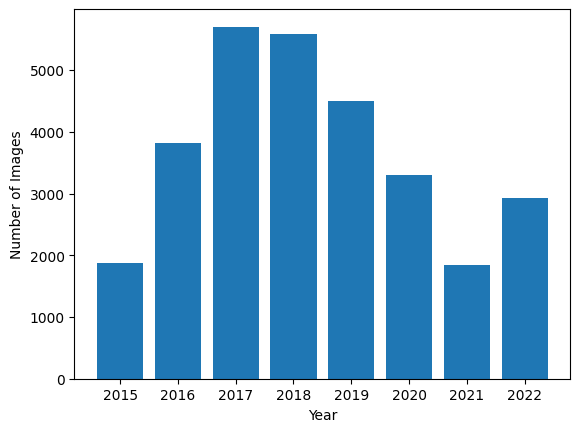

In [7]:
# count the number of images for each year
unique_years, counts = np.unique(years, return_counts=True)
plt.bar(unique_years, counts)
plt.xlabel('Year')
plt.ylabel('Number of Images')
plt.show()
##


# Step 2: Preprocess Images and Combine with GPS Data

In [9]:
# Split the data into training and testing sets
# use 2018 for testing and the rest for training
xtrain = xdata[years != 2018]
ytrain = ydata[years != 2018]
#ytrain = {'heading_normalized': ydata_heading[years != 2018], 'von_mises_output': ydata_vm[years != 2018]}

xtest = xdata[years == 2018]
ytest = ydata[years == 2018]
#ytest = {'heading_normalized': ydata_heading[years == 2018], 'von_mises_output': ydata_vm[years == 2018]}


# Step 3: Model-Specific Preprocessing

In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Create your model based on lag value
if lag == 0:
    # For lag = 0, input shape is (image_size, image_size)
    input_shape = (image_size, image_size)
else:
    # For lag > 0, input shape is (image_size, image_size, lag)
    input_shape = (image_size, image_size, lag)

# Define your model
image_input = layers.Input(shape=input_shape, name='image_input')

# Image processing branch
if lag == 0:
    x = layers.Reshape((image_size, image_size, 1))(image_input)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
else:
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(image_input)

activation_map1 = layers.Activation('relu')(x)  # Save activation map for the first convolutional layer
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
activation_map2 = layers.Activation('relu')(x)  # Save activation map for the second convolutional layer
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
activation_map3 = layers.Activation('relu')(x)  # Save activation map for the third convolutional layer

# Output layer for heading prediction
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
#output_heading = layers.Dense(2, activation='linear', name='heading_output')(output_heading)

# Output layer for von Mises distribution
output_von_mises = layers.Dense(3, activation='linear', name='von_mises_output')(x)
#output_c = layers.Dense(1, activation='softplus', name='vm_concentration')(x)

import tensorflow_probability as tfp
tfd = tfp.distributions

# Keras layer for normalizing the heading output vector to have unit norm
#output_heading = layers.Lambda(lambda x: , name='heading_normalized')(output_von_mises)
output = tfp.layers.DistributionLambda(make_distribution_fn=lambda t: tfd.VonMisesFisher(mean_direction=tf.keras.backend.l2_normalize(t[..., 0:2], axis=1), concentration=tf.math.softplus(t[..., 2])),
                                       convert_to_tensor_fn=lambda s: s.sample(5))(output_von_mises)


# Define the model with multiple outputs
model = models.Model(inputs=image_input, outputs=output)


def von_mises_neg_log_likelihood(y_true, y_pred):
    mean_direction_true = y_true[:, 0]
    concentration_true = y_true[:, 1]
    mean_direction_pred = y_pred[:, 0]
    concentration_pred = y_pred[:, 1]

    von_mises_true = tfp.distributions.VonMises(concentration=concentration_true, loc=mean_direction_true)
    log_likelihood = -von_mises_true.log_prob(mean_direction_pred)

    return tf.reduce_mean(log_likelihood)

# Compile the model with multiple losses
opt = Adam(learning_rate=1e-2)
#model.compile(optimizer=opt, loss='output': von_mises_neg_log_likelihood)


# Create an activation model for visualization
activation_model = models.Model(inputs=model.input, outputs=[activation_map1, activation_map2, activation_map3])

# Display the model summary
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 16, 16, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 8)         80        
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 8)           584       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 8)           584 

In [13]:
np.array(xdata[1][None]).shape

(1, 16, 16, 1)

In [22]:
print(model(xdata[1][None]).mean_direction)
print(model(xdata[1][None]).concentration)

tf.Tensor([[0.18952876 0.9818752 ]], shape=(1, 2), dtype=float32)
tf.Tensor([0.637112], shape=(1,), dtype=float32)


In [23]:
0.18952876**2 + 0.9818752**2

1.0000000592421774

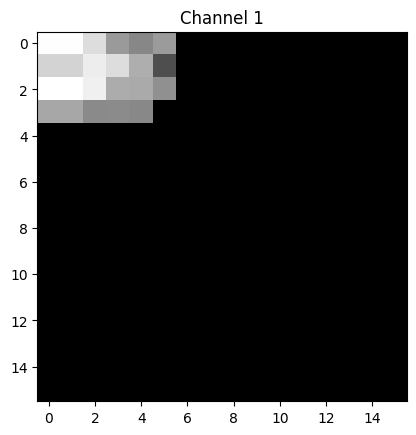

1/1 [==============================] - 2s 2s/step


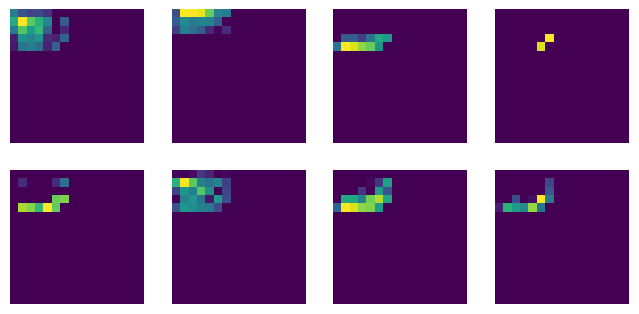

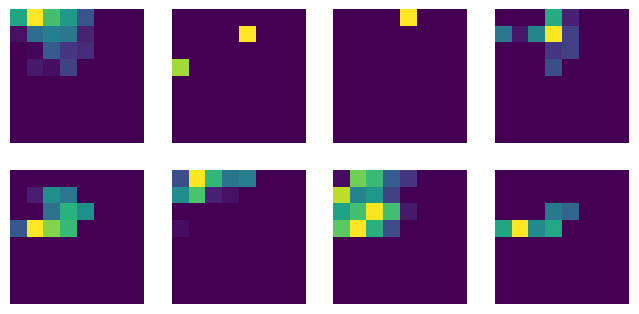

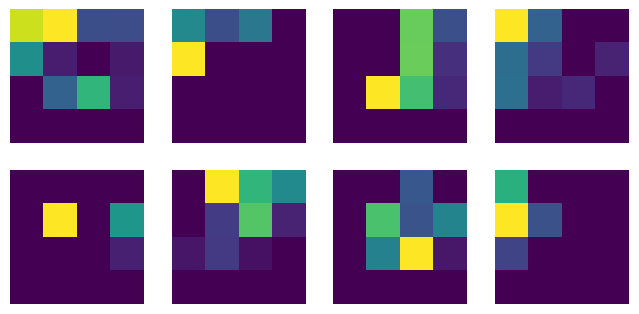

In [11]:
# Now, you can use these activation maps to visualize activations during model training or inference
sample_index = 150  # Choose the index of the sample you want to visualize
sample_image = xdata[sample_index]

# Display each channel separately
for channel in range(sample_image.shape[-1]):
    plt.subplot(1, sample_image.shape[-1], channel + 1)
    plt.imshow(sample_image[:, :, channel], cmap='gray')
    plt.title(f'Channel {channel + 1}')

plt.show()

example_input_image = np.expand_dims(xdata[sample_index], axis=0)
activations1, activations2, activations3 = activation_model.predict(example_input_image)

# Visualize activation maps for the first convolutional layer
plt.figure(figsize=(8, 8))
for i in range(8):  # Assuming 8 filters in the first convolutional layer
    plt.subplot(4, 4, i + 1)
    plt.imshow(activations1[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

# Visualize activation maps for the second convolutional layer
plt.figure(figsize=(8, 8))
for i in range(8):  # Assuming 8 filters in the second convolutional layer
    plt.subplot(4, 4, i + 1)
    plt.imshow(activations2[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

# Visualize activation maps for the third convolutional layer
plt.figure(figsize=(8, 8))
for i in range(8):  # Assuming 8 filters in the third convolutional layer
    plt.subplot(4, 4, i + 1)
    plt.imshow(activations3[0, :, :, i], cmap='viridis')
    plt.axis('off')
plt.show()

# Step 4: Model Training

In [25]:
# fit with early stopping on the validation loss
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

# fit with early stopping on the validation loss
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)

# Data augmentation using ImageDataGenerator
#datagen = ImageDataGenerator(rotation_range=20, horizontal_flip=True)  # You can adjust the rotation_range as needed

# Train the model
model.fit(xtrain, ytrain, batch_size=512,  # Specify steps per epoch based on batch size
          epochs=100,
          validation_data=(xtest, ytest),
          callbacks=[es])



TypeError: 'ImageDataGenerator' object is not callable

# Step 5: Model Evaluation

In [10]:
model.evaluate(xtest, ytest)

175/175 [==============================] - 1s 5ms/step - loss: 0.9426 - heading_normalized_loss: -0.2335 - von_mises_output_loss: 1.1761


[0.9426124095916748, -0.23345759510993958, 1.176070213317871]

In [13]:
# Predict on the train set in batches of 512
for i in range(0,len(xtrain),512):
    preds = model.predict(xtrain[i:i+512],verbose=0)
    if i == 0:
        all_preds_heading = preds[0]
        all_preds_von_mises = preds[1]
    else:
        all_preds_heading = np.concatenate((all_preds_heading,preds[0]),axis=0)
        all_preds_von_mises = np.concatenate((all_preds_von_mises,preds[1]),axis = 0)

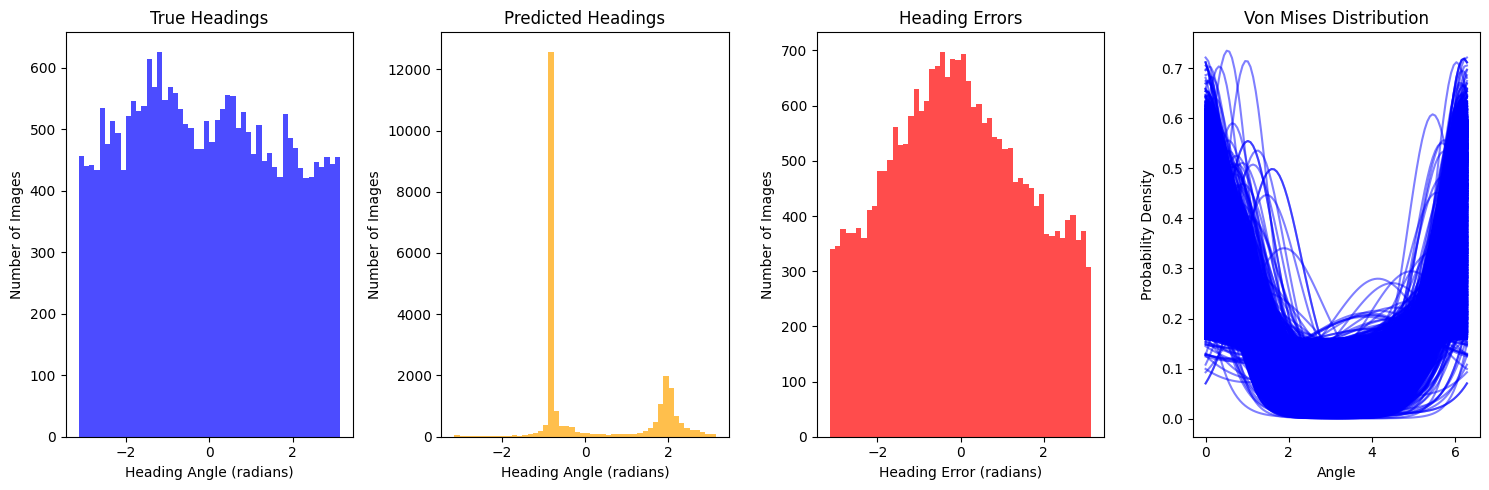

In [15]:
# Calculate heading errors
true_angles = np.arctan2(ytrain['heading_normalized'][:, 1], ytrain['heading_normalized'][:, 0])
#true_angles = np.arctan2(ytrain[:, 1], ytrain[:, 0])
predicted_angles = np.arctan2(all_preds_heading[:, 1], all_preds_heading[:, 0])
heading_errors = true_angles - predicted_angles

# Handle wrapping of angles
heading_errors[heading_errors > np.pi] -= 2 * np.pi
heading_errors[heading_errors < -np.pi] += 2 * np.pi

# Visualize true headings
plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.hist(true_angles, bins=50, color='blue', alpha=0.7)
plt.title('True Headings')
plt.xlabel('Heading Angle (radians)')
plt.ylabel('Number of Images')

# Visualize predicted headings
plt.subplot(1, 4, 2)
plt.hist(predicted_angles, bins=50, color='orange', alpha=0.7)
plt.title('Predicted Headings')
plt.xlabel('Heading Angle (radians)')
plt.ylabel('Number of Images')

# Visualize heading errors
plt.subplot(1, 4, 3)
plt.hist(heading_errors, bins=50, color='red', alpha=0.7)
plt.title('Heading Errors')
plt.xlabel('Heading Error (radians)')
plt.ylabel('Number of Images')

# Assuming von Mises distribution parameters are already normalized
# Extract parameters (mean and concentration)
von_mises_mean = all_preds_von_mises[:, 0]
von_mises_concentration = all_preds_von_mises[:, 1]

# Plot Von Mises distribution
plt.subplot(1, 4, 4)
for i in range(len(von_mises_mean)):
    vm = vonmises(von_mises_mean[i], von_mises_concentration[i])
    plt.plot(np.linspace(0, 2*np.pi, 100), vm.pdf(np.linspace(0, 2*np.pi, 100)), color='b', alpha=0.5)
plt.title('Von Mises Distribution')
plt.xlabel('Angle')
plt.ylabel('Probability Density')

plt.tight_layout()
plt.show()

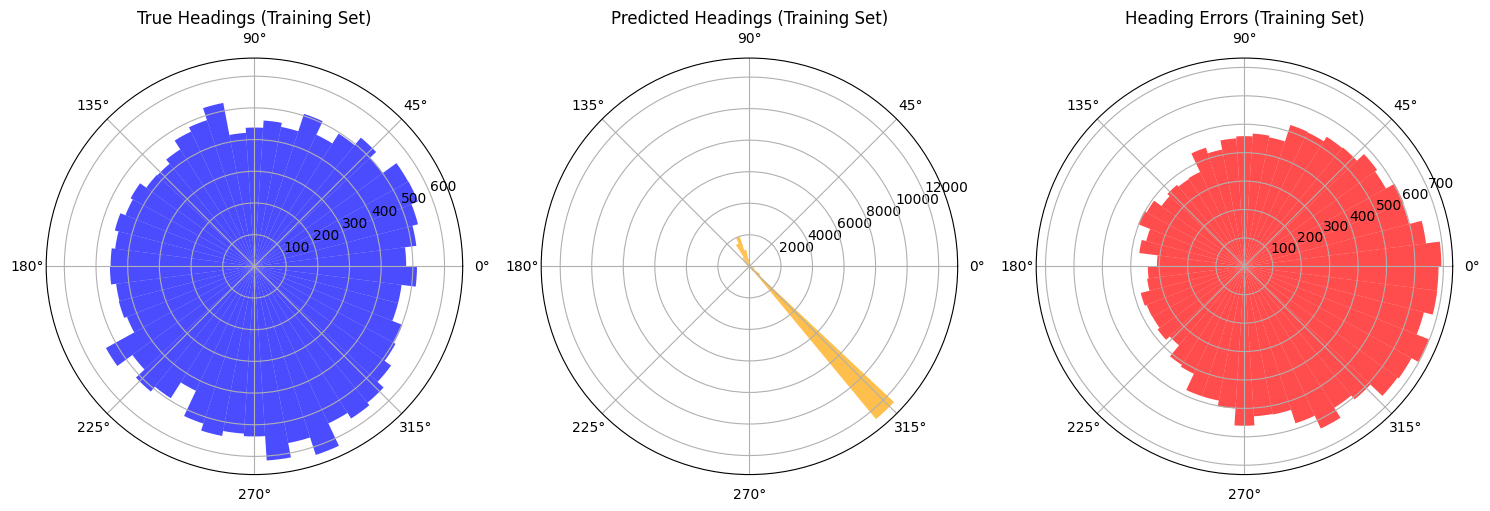

In [16]:
# Create a rose plot for true headings
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1, projection='polar')
plt.hist(true_angles, bins=50, color='blue', alpha=0.7)
plt.title('True Headings (Training Set)')

# Create a rose plot for predicted headings
plt.subplot(1, 3, 2, projection='polar')
plt.hist(predicted_angles, bins=50, color='orange', alpha=0.7)
plt.title('Predicted Headings (Training Set)')

# Create a rose plot for heading errors
plt.subplot(1, 3, 3, projection='polar')
plt.hist(heading_errors, bins=50, color='red', alpha=0.7)
plt.title('Heading Errors (Training Set)')

plt.tight_layout()
plt.show()


In [22]:
preds[:,0]

TypeError: list indices must be integers or slices, not tuple

178/178 [==============================] - 1s 4ms/step


<ipython-input-23-8cb34f1bb638>:54: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 4, 4)
<ipython-input-23-8cb34f1bb638>:63: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


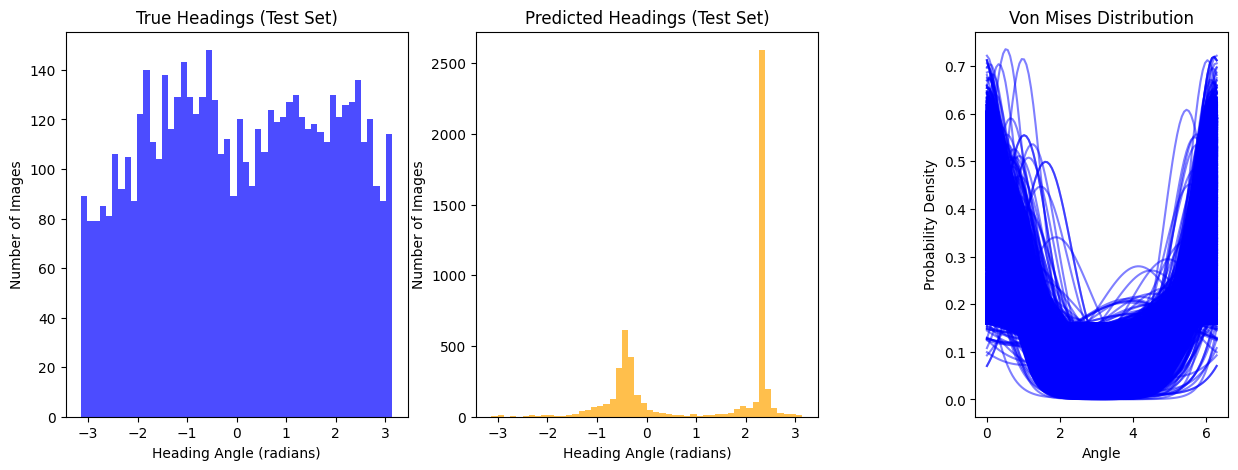

In [23]:
# Predict on the test set
preds = model.predict(xtest)

# Calculate the heading errors
#true_angles = np.arctan2(ytest[:, 1], ytest[:, 0])
#predicted_angles = np.arctan2(preds[:, 1], preds[:, 0])
#heading_errors = true_angles - predicted_angles
# Convert preds to a NumPy array if it's a list
preds_array = np.array(preds)

# Calculate heading errors
true_angles = np.arctan2(ytest['heading_normalized'][:, 1], ytest['heading_normalized'][:, 0])
predicted_angles = np.arctan2(preds_array[0][:, 0], preds_array[0][:, 1])  # Assuming heading output is the first element in preds
heading_errors = true_angles - predicted_angles

# Calculate heading errors
#true_angles = np.arctan2(ytest['heading_normalized'][:, 1], ytest['heading_normalized'][:, 0])
#predicted_angles = np.arctan2(preds[:, 0], preds[:, 1])
#heading_errors = true_angles - predicted_angles

# Handle wrapping of angles
heading_errors[heading_errors > np.pi] -= 2 * np.pi
heading_errors[heading_errors < -np.pi] += 2 * np.pi

# Visualize true headings
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(true_angles, bins=50, color='blue', alpha=0.7)
plt.title('True Headings (Test Set)')
plt.xlabel('Heading Angle (radians)')
plt.ylabel('Number of Images')

# Visualize predicted headings
plt.subplot(1, 3, 2)
plt.hist(predicted_angles, bins=50, color='orange', alpha=0.7)
plt.title('Predicted Headings (Test Set)')
plt.xlabel('Heading Angle (radians)')
plt.ylabel('Number of Images')

# Visualize heading errors
plt.subplot(1, 3, 3)
plt.hist(heading_errors, bins=50, color='red', alpha=0.7)
plt.title('Heading Errors (Test Set)')
plt.xlabel('Heading Error (radians)')
plt.ylabel('Number of Images')

# Assuming von Mises distribution parameters are already normalized
# Extract parameters (mean and concentration)
von_mises_mean = all_preds_von_mises[:, 0]
von_mises_concentration = all_preds_von_mises[:, 1]

# Plot Von Mises distribution
plt.subplot(1, 4, 4)
for i in range(len(von_mises_mean)):
    vm = vonmises(von_mises_mean[i], von_mises_concentration[i])
    plt.plot(np.linspace(0, 2*np.pi, 100), vm.pdf(np.linspace(0, 2*np.pi, 100)), color='b', alpha=0.5)
plt.title('Von Mises Distribution')
plt.xlabel('Angle')
plt.ylabel('Probability Density')


plt.tight_layout()
plt.show()


175/175 [==============================] - 0s 3ms/step


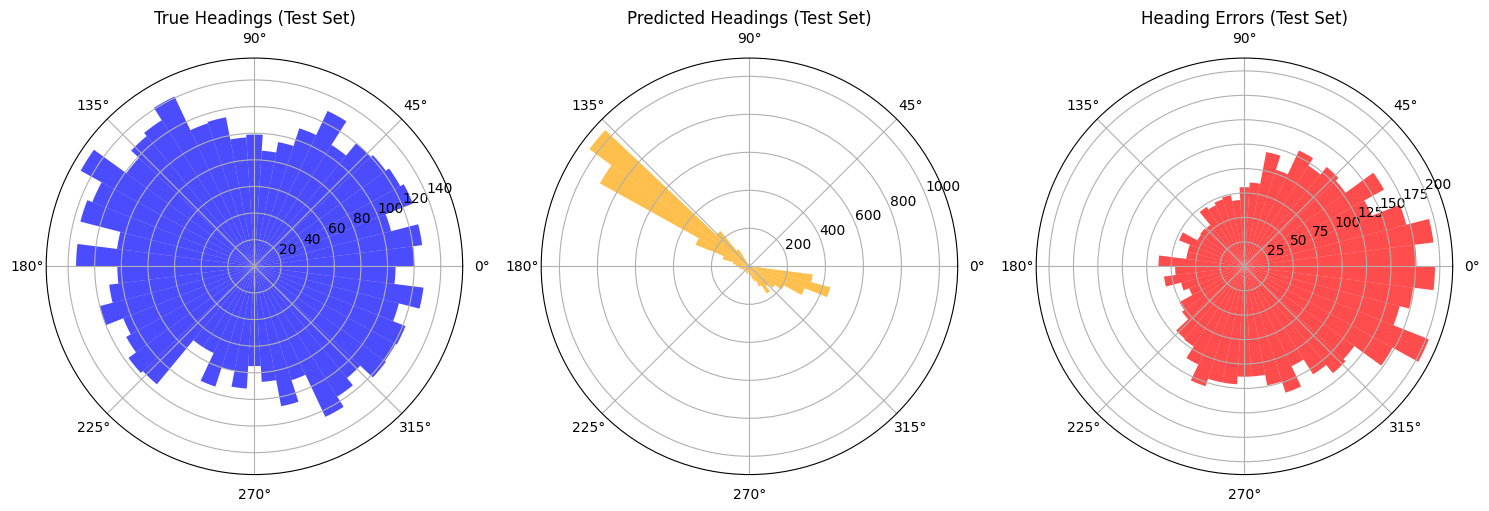

In [ ]:
# Create a rose plot for true headings
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1, projection='polar')
plt.hist(true_angles, bins=50, color='blue', alpha=0.7)
plt.title('True Headings (Test Set)')

# Create a rose plot for predicted headings
plt.subplot(1, 3, 2, projection='polar')
plt.hist(predicted_angles, bins=50, color='orange', alpha=0.7)
plt.title('Predicted Headings (Test Set)')

# Create a rose plot for heading errors
plt.subplot(1, 3, 3, projection='polar')
plt.hist(heading_errors, bins=50, color='red', alpha=0.7)
plt.title('Heading Errors (Test Set)')

plt.tight_layout()
plt.show()


In [ ]:
mae = np.mean(np.abs(a))
print(f"Mean Absolute Error: {mae}")

r_squared = 1 - np.sum(a**2) / np.sum((ytest - np.mean(ytest))**2)
print(f"R-squared: {r_squared}")



Mean Absolute Error: 1.2705133550363672
R-squared: -1.4134227765112746


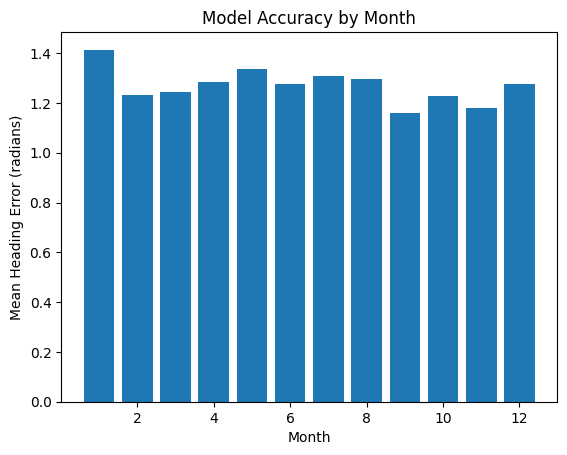

In [ ]:
# Ensure the lengths match by using only the corresponding 'month' values for the test set
test_data_with_month = pd.DataFrame({'heading_error': heading_errors, 'month': gps_data[gps_data['date1'].dt.year == 2018]['month'].values[:len(heading_errors)]})

# Group by month and calculate mean heading error
test_data_with_month['abs_heading_error'] = np.abs(test_data_with_month['heading_error'])
mean_heading_error_by_month = test_data_with_month.groupby('month')['abs_heading_error'].mean()

# Visualize the results
plt.bar(mean_heading_error_by_month.index, mean_heading_error_by_month)
#plt.bar(np.arange(12),mean_heading_error_by_month)
plt.xlabel('Month')
plt.ylabel('Mean Heading Error (radians)')
plt.title('Model Accuracy by Month')
plt.show()

In [ ]:
mean_heading_error_by_month

month
1     1.438293
2     1.215818
3     1.271273
4     1.281442
5     1.299125
6     1.277967
7     1.286276
8     1.306782
9     1.275784
10    1.305092
11    1.264669
12    1.336357
Name: abs_heading_error, dtype: float64

To visualize the average rainfall map aligned with the predicted heading of the wildebeest, you would first need to rotate each rainfall map so that the direction of the wildebeest's movement is aligned with a fixed direction (e.g., upwards). Then, you can average all the rotated maps. Here's a step-by-step guide:




In [ ]:
#Define a function to rotate an image:
from scipy.ndimage import rotate

def rotate_image(image, angle):
    return rotate(image, angle, reshape=False)

#Rotate each rainfall map:
#Assuming rainfall_maps is a list of your rainfall maps and headings is a list of the predicted headings of the wildebeest:

rotated_maps = [rotate_image(map, -heading) for map, heading in zip(xdata, a)]
#Note that we rotate by -heading because a positive rotation is counter-clockwise, but a positive heading is usually clockwise.

#Average the rotated maps:
average_map = np.mean(rotated_maps, axis=0)
average_map_over_time = np.mean(average_map, axis=2)

#Visualize the average map:
average_heading_x = np.cos(a).mean()
average_heading_y = np.sin(a).mean()

plt.imshow(average_map_over_time, cmap='viridis')
plt.quiver(average_map_over_time.shape[1] / 2, average_map_over_time.shape[0] / 2, average_heading_x, average_heading_y, color='r', scale=1)
plt.colorbar()
plt.show()

gradient_y, gradient_x = np.gradient(average_map_over_time)
average_heading_x = np.cos(a).mean()
average_heading_y = np.sin(a).mean()

dot_product = gradient_x * average_heading_x + gradient_y * average_heading_y
correlation = np.corrcoef(dot_product.flatten(), average_map_over_time.flatten())[0, 1]
print(correlation)

plt.scatter(dot_product.flatten(), average_map_over_time.flatten())
plt.xlabel('Dot Product')
plt.ylabel('Rainfall')
plt.title('Correlation between Wildebeest Heading and Rainfall')
plt.show()
0.03970041068468198



Note that we rotate by `-heading` because a positive rotation is counter-clockwise, but a positive heading is usually clockwise.

3. **Average the rotated maps**:



In [ ]:
average_map = np.mean(rotated_maps, axis=0)
average_map_over_time = np.mean(average_map, axis=2)



4. **Visualize the average map**:



In [ ]:
average_heading_x = np.cos(a).mean()
average_heading_y = np.sin(a).mean()

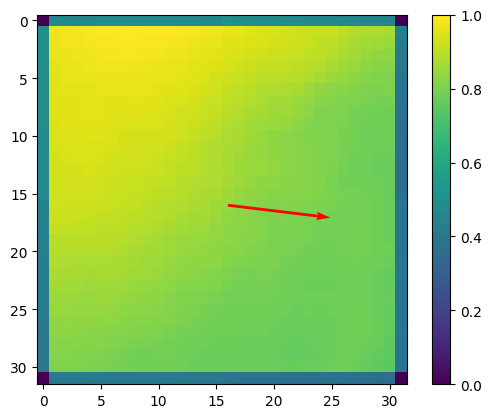

In [ ]:
plt.imshow(average_map_over_time, cmap='viridis')
plt.quiver(average_map_over_time.shape[1] / 2, average_map_over_time.shape[0] / 2, average_heading_x, average_heading_y, color='r', scale=1)
plt.colorbar()
plt.show()

In [ ]:
gradient_y, gradient_x = np.gradient(average_map_over_time)
average_heading_x = np.cos(a).mean()
average_heading_y = np.sin(a).mean()

dot_product = gradient_x * average_heading_x + gradient_y * average_heading_y

0.03970041068468198


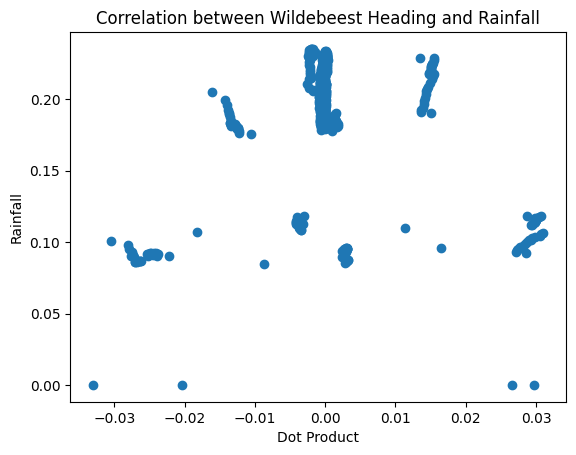

In [ ]:
correlation = np.corrcoef(dot_product.flatten(), average_map_over_time.flatten())[0, 1]
print(correlation)

plt.scatter(dot_product.flatten(), average_map_over_time.flatten())
plt.xlabel('Dot Product')
plt.ylabel('Rainfall')
plt.title('Correlation between Wildebeest Heading and Rainfall')
plt.show()

In [ ]:
from tqdm import tqdm
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def create_and_train_model(gps_data, ds, image_size, step, lag):
    # Create an empty array to store image-GPS pairs
    xdata = np.zeros((len(gps_data), image_size, image_size, lag))
    ydata = np.zeros((len(gps_data), 2))
    years = np.zeros(len(gps_data))

    i = 0
    for uid in tqdm(gps_data['ID'].unique()):
        current_data = gps_data[gps_data['ID'] == uid]
        for index, row in current_data.iterrows():
            center_x = row['x1_']
            center_y = row['y1_']
            center_date = row['date1']

            next_date = center_date + pd.Timedelta(days=step)
            next_data = current_data[current_data['date1'] == next_date]
            if len(next_data) == 0:
                continue
            next_x = next_data['x1_'].values[0]
            next_y = next_data['y1_'].values[0]
            ydata[i] = [next_x - center_x, next_y - center_y]

            x_index = np.abs(ds.x - center_x).argmin().values
            y_index = np.abs(ds.y - center_y).argmin().values
            time_index = np.abs(ds.time - np.datetime64(center_date)).argmin().values
            if time_index - lag < 0:
                continue

            subset = ds.isel(x=slice(x_index - image_size // 2, x_index + image_size // 2),
                             y=slice(y_index - image_size // 2, y_index + image_size // 2),
                             time=slice(time_index - lag + 1, time_index + 1))

            data_array = subset.rainfall.values

            if np.isnan(data_array).any() or np.isinf(data_array).any():
                print(f"Warning: NaN or infinite values found in data_array for ID {uid}, index {index}, time_index {time_index}")
                print(f"NaN values: {np.sum(np.isnan(data_array))}")
                print(f"Infinite values: {np.sum(np.isinf(data_array))}")

            data_array = np.nan_to_num(data_array)
            data_array = np.transpose(data_array, [1, 2, 0])

            xdata[i] = data_array
            years[i] = center_date.year
            i += 1

    # Truncate arrays to actual data size
    xdata = xdata[:i]
    ydata = ydata[:i]
    years = years[:i]

    # Preprocess data
    xdata = xdata.astype('float32')
    xdata = xdata / np.percentile(xdata, 95)
    ydata = ydata.astype('float32')
    ydata = ydata / np.linalg.norm(ydata, axis=1, keepdims=True)

    # Split data
    xtrain = xdata[years != 2018]
    ytrain = ydata[years != 2018]
    xtest = xdata[years == 2018]
    ytest = ydata[years == 2018]

    # Model definition
    image_input = layers.Input(shape=(image_size, image_size, lag), name='image_input')
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation='relu')(x)
    output = layers.Dense(2, activation='linear')(x)
    output = layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1))(output)
    model = models.Model(inputs=image_input, outputs=output)

    # Model compilation
    opt = Adam(learning_rate=1e-2)
    model.compile(optimizer=opt, loss=tf.keras.losses.CosineSimilarity(axis=-1))

    # Model training
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=True)
    model.fit(xtrain, ytrain, epochs=100, validation_data=(xtest, ytest), callbacks=[es], batch_size=512)

    # Evaluate the model
    loss = model.evaluate(xtest, ytest)
    return model, loss

# Define ranges for hyperparameters
image_sizes = [16, 20, 24, 32]
steps = [1, 3, 7, 10, 16]
lags = [1, 3, 5, 7, 10]

best_model = None
best_loss = float('inf')  # Initialize to a large value

# Iterate over hyperparameters
for image_size in image_sizes:
    for step in steps:
        for lag in lags:
            print(f"\nTraining model with image_size={image_size}, step={step}, lag={lag}")
            current_model, current_loss = create_and_train_model(gps_data, ds, image_size, step, lag)

            # Check if this set of parameters is the best so far
            if current_loss < best_loss:
                best_loss = current_loss
                best_model = current_model

# Evaluate the best model on the test set after the loop
best_model.evaluate(xtest, ytest)

print("Best model has been found.")




Training model with image_size=16, step=1, lag=1


100%|██████████| 59/59 [02:22<00:00,  2.42s/it]


Epoch 1/100
50/50 [==============================] - 6s 11ms/step - loss: -0.0707 - val_loss: -0.1389
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: -0.0957 - val_loss: -0.1377
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1025 - val_loss: -0.1356
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1041 - val_loss: -0.1484
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1047 - val_loss: -0.1391
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1078 - val_loss: -0.1075
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1021 - val_loss: -0.1362
Epoch 8/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1078 - val_loss: -0.1394
Epoch 9/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1094 - val_loss: -0.1205
Epoch 9: early stopping
181/181 [==============================] - 1s 4ms/step - loss: -0.

100%|██████████| 59/59 [02:26<00:00,  2.48s/it]


Epoch 1/100
50/50 [==============================] - 2s 13ms/step - loss: -0.0986 - val_loss: -0.1329
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1179 - val_loss: -0.1514
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1143 - val_loss: -0.1446
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1268 - val_loss: -0.1538
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1283 - val_loss: -0.1502
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1334 - val_loss: -0.1575
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1385 - val_loss: -0.1555
Epoch 8/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1396 - val_loss: -0.1602
Epoch 9/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1463 - val_loss: -0.1496
Epoch 10/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1329 - val_lo

100%|██████████| 59/59 [02:27<00:00,  2.51s/it]


Epoch 1/100
50/50 [==============================] - 2s 14ms/step - loss: -0.1038 - val_loss: -0.1324
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1110 - val_loss: -0.1534
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1213 - val_loss: -0.1505
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1358 - val_loss: -0.1585
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1342 - val_loss: -0.1564
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1433 - val_loss: -0.1567
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1450 - val_loss: -0.1692
Epoch 8/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1487 - val_loss: -0.1652
Epoch 9/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1542 - val_loss: -0.1613
Epoch 10/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1530 - val_lo

100%|██████████| 59/59 [02:27<00:00,  2.50s/it]


Epoch 1/100
50/50 [==============================] - 2s 16ms/step - loss: -0.0937 - val_loss: -0.1549
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1275 - val_loss: -0.1792
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1323 - val_loss: -0.1650
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1463 - val_loss: -0.1601
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1467 - val_loss: -0.1438
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1414 - val_loss: -0.1605
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1467 - val_loss: -0.1667
Epoch 7: early stopping
181/181 [==============================] - 0s 2ms/step - loss: -0.1792

Training model with image_size=16, step=1, lag=10


100%|██████████| 59/59 [02:28<00:00,  2.52s/it]


Epoch 1/100
50/50 [==============================] - 3s 24ms/step - loss: -0.0950 - val_loss: -0.1070
Epoch 2/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1217 - val_loss: -0.1384
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1096 - val_loss: -0.1427
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1306 - val_loss: -0.1599
Epoch 5/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1323 - val_loss: -0.1411
Epoch 6/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1475 - val_loss: -0.1592
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1543 - val_loss: -0.1781
Epoch 8/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1600 - val_loss: -0.1742
Epoch 9/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1519 - val_loss: -0.1306
Epoch 10/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1446 - val_lo

100%|██████████| 59/59 [02:21<00:00,  2.40s/it]


Epoch 1/100
49/49 [==============================] - 2s 13ms/step - loss: -0.1295 - val_loss: -0.1785
Epoch 2/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1440 - val_loss: -0.1781
Epoch 3/100
49/49 [==============================] - 0s 5ms/step - loss: -0.1458 - val_loss: -0.1656
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1501 - val_loss: -0.1848
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1499 - val_loss: -0.1751
Epoch 6/100
49/49 [==============================] - 0s 5ms/step - loss: -0.1452 - val_loss: -0.1808
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1509 - val_loss: -0.1794
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1463 - val_loss: -0.1767
Epoch 9/100
49/49 [==============================] - 0s 8ms/step - loss: -0.1522 - val_loss: -0.1754
Epoch 9: early stopping
178/178 [==============================] - 1s 6ms/step - loss: -0.

100%|██████████| 59/59 [02:24<00:00,  2.45s/it]


Epoch 1/100
49/49 [==============================] - 2s 13ms/step - loss: -0.1444 - val_loss: -0.2016
Epoch 2/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1612 - val_loss: -0.2076
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1590 - val_loss: -0.1746
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1737 - val_loss: -0.1896
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1792 - val_loss: -0.1960
Epoch 6/100
49/49 [==============================] - 0s 5ms/step - loss: -0.1790 - val_loss: -0.1929
Epoch 7/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1725 - val_loss: -0.1952
Epoch 7: early stopping
178/178 [==============================] - 0s 2ms/step - loss: -0.2076

Training model with image_size=16, step=3, lag=5


100%|██████████| 59/59 [02:23<00:00,  2.43s/it]


Epoch 1/100
49/49 [==============================] - 2s 14ms/step - loss: -0.1309 - val_loss: -0.1800
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1662 - val_loss: -0.1992
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1880 - val_loss: -0.1984
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1855 - val_loss: -0.2134
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1868 - val_loss: -0.1818
Epoch 6/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1846 - val_loss: -0.1983
Epoch 7/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1958 - val_loss: -0.2127
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1755 - val_loss: -0.1973
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1906 - val_loss: -0.2134
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2003 - val_lo

100%|██████████| 59/59 [02:23<00:00,  2.43s/it]


Epoch 1/100
49/49 [==============================] - 3s 30ms/step - loss: -0.1170 - val_loss: -0.1860
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: -0.1430 - val_loss: -0.2073
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: -0.1734 - val_loss: -0.2021
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1889 - val_loss: -0.2222
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: -0.1980 - val_loss: -0.2169
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2072 - val_loss: -0.2228
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1904 - val_loss: -0.2066
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2076 - val_loss: -0.2135
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2141 - val_loss: -0.2208
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2146 - val_lo

100%|██████████| 59/59 [02:25<00:00,  2.47s/it]


Epoch 1/100
49/49 [==============================] - 3s 22ms/step - loss: -0.0561 - val_loss: -0.0737
Epoch 2/100
49/49 [==============================] - 1s 10ms/step - loss: -0.1386 - val_loss: -0.1493
Epoch 3/100
49/49 [==============================] - 1s 13ms/step - loss: -0.1609 - val_loss: -0.1823
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: -0.1813 - val_loss: -0.1854
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: -0.1944 - val_loss: -0.2007
Epoch 6/100
49/49 [==============================] - 0s 8ms/step - loss: -0.1989 - val_loss: -0.2050
Epoch 7/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2090 - val_loss: -0.1966
Epoch 8/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2161 - val_loss: -0.2303
Epoch 9/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2219 - val_loss: -0.2292
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2287 - val_

100%|██████████| 59/59 [02:17<00:00,  2.33s/it]


Epoch 1/100
47/47 [==============================] - 2s 13ms/step - loss: -0.1312 - val_loss: -0.2042
Epoch 2/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1474 - val_loss: -0.1921
Epoch 3/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1459 - val_loss: -0.2092
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1529 - val_loss: -0.2100
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1556 - val_loss: -0.2072
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1562 - val_loss: -0.1988
Epoch 7/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1594 - val_loss: -0.1861
Epoch 8/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1533 - val_loss: -0.2034
Epoch 9/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1536 - val_loss: -0.2111
Epoch 10/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1573 - val_lo

100%|██████████| 59/59 [02:18<00:00,  2.36s/it]


Epoch 1/100
47/47 [==============================] - 2s 13ms/step - loss: -0.1235 - val_loss: -0.1658
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1453 - val_loss: -0.2036
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1599 - val_loss: -0.2056
Epoch 4/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1646 - val_loss: -0.1879
Epoch 5/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1647 - val_loss: -0.2041
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1746 - val_loss: -0.1893
Epoch 7/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1805 - val_loss: -0.2022
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1848 - val_loss: -0.2058
Epoch 9/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1872 - val_loss: -0.2019
Epoch 10/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1891 - val_lo

100%|██████████| 59/59 [02:18<00:00,  2.35s/it]


Epoch 1/100
47/47 [==============================] - 2s 14ms/step - loss: -0.1228 - val_loss: -0.2097
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1732 - val_loss: -0.2034
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1844 - val_loss: -0.2164
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1895 - val_loss: -0.2038
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1949 - val_loss: -0.2297
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2038 - val_loss: -0.1874
Epoch 7/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1976 - val_loss: -0.2104
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: -0.2107 - val_loss: -0.2169
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2094 - val_loss: -0.2232
Epoch 10/100
47/47 [==============================] - 0s 6ms/step - loss: -0.2120 - val_lo

100%|██████████| 59/59 [02:18<00:00,  2.35s/it]


Epoch 1/100
47/47 [==============================] - 2s 16ms/step - loss: -0.0915 - val_loss: -0.1668
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1479 - val_loss: -0.1818
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1615 - val_loss: -0.1889
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1642 - val_loss: -0.1975
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1815 - val_loss: -0.2131
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: -0.0750 - val_loss: -0.0590
Epoch 7/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1009 - val_loss: -0.1654
Epoch 8/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1864 - val_loss: -0.2124
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2015 - val_loss: -0.2185
Epoch 10/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1934 - val_lo

100%|██████████| 59/59 [02:19<00:00,  2.36s/it]


Epoch 1/100
47/47 [==============================] - 3s 18ms/step - loss: -0.1168 - val_loss: -0.1955
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1591 - val_loss: -0.2101
Epoch 3/100
47/47 [==============================] - 0s 8ms/step - loss: -0.1814 - val_loss: -0.2446
Epoch 4/100
47/47 [==============================] - 0s 8ms/step - loss: -0.1900 - val_loss: -0.2678
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2080 - val_loss: -0.2491
Epoch 6/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2060 - val_loss: -0.2613
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2183 - val_loss: -0.2539
Epoch 8/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2267 - val_loss: -0.2723
Epoch 9/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2215 - val_loss: -0.2481
Epoch 10/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2150 - val_lo

100%|██████████| 59/59 [02:14<00:00,  2.29s/it]


Epoch 1/100
46/46 [==============================] - 2s 16ms/step - loss: -0.1220 - val_loss: -0.1769
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: -0.1419 - val_loss: -0.1895
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1508 - val_loss: -0.1824
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: -0.1519 - val_loss: -0.1903
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1622 - val_loss: -0.1685
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1587 - val_loss: -0.1837
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1633 - val_loss: -0.1881
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1705 - val_loss: -0.1974
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1644 - val_loss: -0.1879
Epoch 10/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1702 - val_lo

100%|██████████| 59/59 [02:16<00:00,  2.32s/it]


Epoch 1/100
46/46 [==============================] - 2s 14ms/step - loss: -0.1264 - val_loss: -0.1869
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1542 - val_loss: -0.1888
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1627 - val_loss: -0.1972
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1682 - val_loss: -0.1655
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1630 - val_loss: -0.1831
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1795 - val_loss: -0.2047
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1868 - val_loss: -0.2149
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1821 - val_loss: -0.2015
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1902 - val_loss: -0.2120
Epoch 10/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1922 - val_lo

100%|██████████| 59/59 [02:15<00:00,  2.30s/it]


Epoch 1/100
46/46 [==============================] - 3s 15ms/step - loss: -0.1195 - val_loss: -0.2081
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: -0.0790 - val_loss: -0.0855
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1183 - val_loss: -0.2041
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1498 - val_loss: -0.2023
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1708 - val_loss: -0.2158
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1738 - val_loss: -0.1721
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1637 - val_loss: -0.2094
Epoch 8/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1807 - val_loss: -0.2143
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1867 - val_loss: -0.2197
Epoch 10/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1918 - val_lo

100%|██████████| 59/59 [02:19<00:00,  2.37s/it]


Epoch 1/100
46/46 [==============================] - 2s 17ms/step - loss: -0.0949 - val_loss: -0.1278
Epoch 2/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1292 - val_loss: -0.1910
Epoch 3/100
46/46 [==============================] - 0s 11ms/step - loss: -0.1571 - val_loss: -0.2091
Epoch 4/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1712 - val_loss: -0.2088
Epoch 5/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1785 - val_loss: -0.2051
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1769 - val_loss: -0.2156
Epoch 7/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1880 - val_loss: -0.2116
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2001 - val_loss: -0.2072
Epoch 9/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1998 - val_loss: -0.1807
Epoch 10/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2088 -

100%|██████████| 59/59 [02:21<00:00,  2.39s/it]


Epoch 1/100
46/46 [==============================] - 2s 20ms/step - loss: -0.0452 - val_loss: -0.0578
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: -0.0893 - val_loss: -0.1979
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1555 - val_loss: -0.2202
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1811 - val_loss: -0.2434
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1930 - val_loss: -0.2285
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: -0.2067 - val_loss: -0.2536
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: -0.2091 - val_loss: -0.2277
Epoch 8/100
46/46 [==============================] - 0s 8ms/step - loss: -0.2114 - val_loss: -0.2696
Epoch 9/100
46/46 [==============================] - 0s 8ms/step - loss: -0.2267 - val_loss: -0.2655
Epoch 10/100
46/46 [==============================] - 0s 8ms/step - loss: -0.2279 - val_lo

100%|██████████| 59/59 [02:17<00:00,  2.34s/it]


Epoch 1/100
46/46 [==============================] - 2s 15ms/step - loss: -0.0727 - val_loss: -0.1770
Epoch 2/100
46/46 [==============================] - 0s 5ms/step - loss: -0.1048 - val_loss: -0.1745
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1127 - val_loss: -0.1751
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1174 - val_loss: -0.1871
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1225 - val_loss: -0.1749
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: -0.1231 - val_loss: -0.1784
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1188 - val_loss: -0.1847
Epoch 8/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1270 - val_loss: -0.1768
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1315 - val_loss: -0.1794
Epoch 9: early stopping
174/174 [==============================] - 0s 3ms/step - loss: -0.

100%|██████████| 59/59 [02:18<00:00,  2.34s/it]


Epoch 1/100
46/46 [==============================] - 2s 13ms/step - loss: -0.0725 - val_loss: -0.1463
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1055 - val_loss: -0.1688
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1085 - val_loss: -0.1979
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1265 - val_loss: -0.2043
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1381 - val_loss: -0.1932
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1549 - val_loss: -0.2055
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1596 - val_loss: -0.1834
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1691 - val_loss: -0.1997
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1515 - val_loss: 0.0044
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: -0.0552 - val_los

100%|██████████| 59/59 [02:18<00:00,  2.35s/it]


Epoch 1/100
46/46 [==============================] - 2s 14ms/step - loss: -0.0803 - val_loss: -0.2222
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1359 - val_loss: -0.2267
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1524 - val_loss: -0.2229
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1562 - val_loss: -0.2334
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1691 - val_loss: -0.2293
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1802 - val_loss: -0.2332
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1829 - val_loss: -0.2210
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1866 - val_loss: -0.2155
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1941 - val_loss: -0.2203
Epoch 9: early stopping
174/174 [==============================] - 0s 2ms/step - loss: -0.

100%|██████████| 59/59 [02:18<00:00,  2.35s/it]


Epoch 1/100
46/46 [==============================] - 2s 16ms/step - loss: -0.0592 - val_loss: -0.1046
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: -0.0788 - val_loss: -0.1812
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: -0.0665 - val_loss: -0.1706
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: -0.0924 - val_loss: -0.1842
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1296 - val_loss: -0.2273
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1407 - val_loss: -0.1690
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1287 - val_loss: -0.1868
Epoch 8/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1711 - val_loss: -0.1903
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1767 - val_loss: -0.2265
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1973 - val_lo

100%|██████████| 59/59 [02:18<00:00,  2.35s/it]


Epoch 1/100
46/46 [==============================] - 2s 20ms/step - loss: -0.0624 - val_loss: -0.1093
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: -0.0862 - val_loss: -0.1359
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1230 - val_loss: -0.1914
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1449 - val_loss: -0.2225
Epoch 5/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1556 - val_loss: -0.1966
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1385 - val_loss: -0.2278
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1711 - val_loss: -0.2396
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1748 - val_loss: -0.2519
Epoch 9/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1930 - val_loss: -0.2423
Epoch 10/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1952 - val_lo

100%|██████████| 59/59 [02:25<00:00,  2.46s/it]


Epoch 1/100
50/50 [==============================] - 2s 10ms/step - loss: -0.0404 - val_loss: -0.0282
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: -0.0862 - val_loss: -0.1412
Epoch 3/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1047 - val_loss: -0.1300
Epoch 4/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1011 - val_loss: -0.1456
Epoch 5/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1064 - val_loss: -0.1514
Epoch 6/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1068 - val_loss: -0.1409
Epoch 7/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1111 - val_loss: -0.1361
Epoch 8/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1104 - val_loss: -0.1534
Epoch 9/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1148 - val_loss: -0.1400
Epoch 10/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1034 - val_lo

100%|██████████| 59/59 [02:25<00:00,  2.46s/it]


Epoch 1/100
50/50 [==============================] - 3s 19ms/step - loss: -0.0986 - val_loss: -0.1361
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1269 - val_loss: -0.1528
Epoch 3/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1305 - val_loss: -0.1482
Epoch 4/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1315 - val_loss: -0.1384
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1356 - val_loss: -0.1471
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1401 - val_loss: -0.1419
Epoch 7/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1394 - val_loss: -0.1482
Epoch 7: early stopping
181/181 [==============================] - 0s 2ms/step - loss: -0.1528

Training model with image_size=20, step=1, lag=5


100%|██████████| 59/59 [02:28<00:00,  2.51s/it]


Epoch 1/100
50/50 [==============================] - 2s 17ms/step - loss: -0.0589 - val_loss: -0.1456
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1061 - val_loss: -0.1514
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1280 - val_loss: -0.1715
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1398 - val_loss: -0.1437
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1270 - val_loss: -0.1799
Epoch 6/100
50/50 [==============================] - 1s 11ms/step - loss: -0.1452 - val_loss: -0.1779
Epoch 7/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1392 - val_loss: -0.1616
Epoch 8/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1422 - val_loss: -0.1615
Epoch 9/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1518 - val_loss: -0.1706
Epoch 10/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1456 - v

100%|██████████| 59/59 [02:30<00:00,  2.55s/it]


Epoch 1/100
50/50 [==============================] - 3s 22ms/step - loss: -0.0523 - val_loss: -0.0189
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: -0.0989 - val_loss: -0.1569
Epoch 3/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1145 - val_loss: -0.1511
Epoch 4/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1365 - val_loss: -0.1811
Epoch 5/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1531 - val_loss: -0.1878
Epoch 6/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1512 - val_loss: -0.1808
Epoch 7/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1614 - val_loss: -0.1836
Epoch 8/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1623 - val_loss: -0.1793
Epoch 9/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1719 - val_loss: -0.1806
Epoch 10/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1707 - val_lo

100%|██████████| 59/59 [02:32<00:00,  2.59s/it]


Epoch 1/100
50/50 [==============================] - 3s 22ms/step - loss: -0.0636 - val_loss: -0.1134
Epoch 2/100
50/50 [==============================] - 1s 11ms/step - loss: -0.0962 - val_loss: -0.1538
Epoch 3/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1251 - val_loss: -0.1322
Epoch 4/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1194 - val_loss: -0.1221
Epoch 5/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1287 - val_loss: -0.1565
Epoch 6/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1478 - val_loss: -0.1629
Epoch 7/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1549 - val_loss: -0.1714
Epoch 8/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1615 - val_loss: -0.1626
Epoch 9/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1553 - val_loss: -0.1835
Epoch 10/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1675

100%|██████████| 59/59 [02:23<00:00,  2.43s/it]


Epoch 1/100
49/49 [==============================] - 2s 14ms/step - loss: -0.1300 - val_loss: -0.1793
Epoch 2/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1387 - val_loss: -0.1825
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1501 - val_loss: -0.1842
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1517 - val_loss: -0.1844
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1540 - val_loss: -0.1710
Epoch 6/100
49/49 [==============================] - 0s 5ms/step - loss: -0.1553 - val_loss: -0.1846
Epoch 7/100
49/49 [==============================] - 0s 5ms/step - loss: -0.1549 - val_loss: -0.1911
Epoch 8/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1589 - val_loss: -0.1872
Epoch 9/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1592 - val_loss: -0.1861
Epoch 10/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1641 - val_lo

100%|██████████| 59/59 [02:23<00:00,  2.44s/it]


Epoch 1/100
49/49 [==============================] - 2s 14ms/step - loss: -0.1389 - val_loss: -0.1936
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1442 - val_loss: -0.1781
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1687 - val_loss: -0.1838
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1785 - val_loss: -0.2006
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1824 - val_loss: -0.1708
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1771 - val_loss: -0.2003
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1856 - val_loss: -0.2077
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1859 - val_loss: -0.2069
Epoch 9/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1881 - val_loss: -0.1974
Epoch 10/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1897 - val_lo

100%|██████████| 59/59 [02:23<00:00,  2.44s/it]


Epoch 1/100
49/49 [==============================] - 3s 16ms/step - loss: -0.1170 - val_loss: -0.1982
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1754 - val_loss: -0.2016
Epoch 3/100
49/49 [==============================] - 0s 8ms/step - loss: -0.1861 - val_loss: -0.2024
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: -0.1879 - val_loss: -0.2077
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1949 - val_loss: -0.2302
Epoch 6/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2004 - val_loss: -0.2248
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2018 - val_loss: -0.2008
Epoch 8/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2024 - val_loss: -0.2272
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1996 - val_loss: -0.2271
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2103 - val_lo

100%|██████████| 59/59 [02:26<00:00,  2.48s/it]


Epoch 1/100
49/49 [==============================] - 2s 19ms/step - loss: -0.1289 - val_loss: -0.1987
Epoch 2/100
49/49 [==============================] - 1s 10ms/step - loss: -0.1717 - val_loss: -0.1593
Epoch 3/100
49/49 [==============================] - 1s 13ms/step - loss: -0.1710 - val_loss: -0.2127
Epoch 4/100
49/49 [==============================] - 1s 12ms/step - loss: -0.1818 - val_loss: -0.2200
Epoch 5/100
49/49 [==============================] - 1s 12ms/step - loss: -0.1840 - val_loss: -0.1996
Epoch 6/100
49/49 [==============================] - 1s 11ms/step - loss: -0.2050 - val_loss: -0.2329
Epoch 7/100
49/49 [==============================] - 1s 13ms/step - loss: -0.2108 - val_loss: -0.2206
Epoch 8/100
49/49 [==============================] - 1s 12ms/step - loss: -0.2130 - val_loss: -0.2150
Epoch 9/100
49/49 [==============================] - 1s 14ms/step - loss: -0.2149 - val_loss: -0.2161
Epoch 10/100
49/49 [==============================] - 0s 10ms/step - loss: -0.2210

100%|██████████| 59/59 [02:26<00:00,  2.48s/it]


Epoch 1/100
49/49 [==============================] - 3s 25ms/step - loss: -0.0841 - val_loss: -0.1502
Epoch 2/100
49/49 [==============================] - 1s 15ms/step - loss: -0.1493 - val_loss: -0.2067
Epoch 3/100
49/49 [==============================] - 1s 15ms/step - loss: -0.1832 - val_loss: -0.2305
Epoch 4/100
49/49 [==============================] - 1s 14ms/step - loss: -0.1970 - val_loss: -0.2135
Epoch 5/100
49/49 [==============================] - 1s 13ms/step - loss: -0.1963 - val_loss: -0.2297
Epoch 6/100
49/49 [==============================] - 1s 16ms/step - loss: -0.2115 - val_loss: -0.2216
Epoch 7/100
49/49 [==============================] - 1s 16ms/step - loss: -0.2128 - val_loss: -0.2439
Epoch 8/100
49/49 [==============================] - 1s 13ms/step - loss: -0.2173 - val_loss: -0.2315
Epoch 9/100
49/49 [==============================] - 1s 13ms/step - loss: -0.2284 - val_loss: -0.1977
Epoch 10/100
49/49 [==============================] - 1s 11ms/step - loss: -0.2084

100%|██████████| 59/59 [02:17<00:00,  2.34s/it]


Epoch 1/100
47/47 [==============================] - 3s 16ms/step - loss: -0.0975 - val_loss: -0.1852
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1446 - val_loss: -0.1924
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1462 - val_loss: -0.2049
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1531 - val_loss: -0.1908
Epoch 5/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1396 - val_loss: -0.1901
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1424 - val_loss: -0.2033
Epoch 7/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1535 - val_loss: -0.2052
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1564 - val_loss: -0.2051
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1596 - val_loss: -0.2055
Epoch 10/100
47/47 [==============================] - 0s 5ms/step - loss: -0.1601 - val_lo

100%|██████████| 59/59 [02:19<00:00,  2.37s/it]


Epoch 1/100
47/47 [==============================] - 2s 15ms/step - loss: -0.0943 - val_loss: -0.2074
Epoch 2/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1632 - val_loss: -0.2013
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1762 - val_loss: -0.2055
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1742 - val_loss: -0.2189
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1813 - val_loss: -0.2232
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1802 - val_loss: -0.2125
Epoch 7/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1897 - val_loss: -0.2087
Epoch 8/100
47/47 [==============================] - 0s 6ms/step - loss: -0.2016 - val_loss: -0.2246
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2017 - val_loss: -0.2138
Epoch 10/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2080 - val_lo

100%|██████████| 59/59 [02:20<00:00,  2.39s/it]


Epoch 1/100
47/47 [==============================] - 2s 17ms/step - loss: -0.1263 - val_loss: -0.1916
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1683 - val_loss: -0.2320
Epoch 3/100
47/47 [==============================] - 0s 8ms/step - loss: -0.1892 - val_loss: -0.2319
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1931 - val_loss: -0.2103
Epoch 5/100
47/47 [==============================] - 0s 8ms/step - loss: -0.1884 - val_loss: -0.2478
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2011 - val_loss: -0.2363
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2017 - val_loss: -0.2391
Epoch 8/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2098 - val_loss: -0.2140
Epoch 9/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1941 - val_loss: -0.2187
Epoch 10/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2145 - val_lo

100%|██████████| 59/59 [02:22<00:00,  2.42s/it]


Epoch 1/100
47/47 [==============================] - 3s 25ms/step - loss: -0.1150 - val_loss: -0.2168
Epoch 2/100
47/47 [==============================] - 1s 11ms/step - loss: -0.1843 - val_loss: -0.0790
Epoch 3/100
47/47 [==============================] - 1s 13ms/step - loss: -0.1378 - val_loss: -0.2106
Epoch 4/100
47/47 [==============================] - 1s 11ms/step - loss: -0.1813 - val_loss: -0.2211
Epoch 5/100
47/47 [==============================] - 0s 9ms/step - loss: -0.1995 - val_loss: -0.2174
Epoch 6/100
47/47 [==============================] - 0s 9ms/step - loss: -0.2058 - val_loss: -0.2243
Epoch 7/100
47/47 [==============================] - 0s 9ms/step - loss: -0.2128 - val_loss: -0.2230
Epoch 8/100
47/47 [==============================] - 0s 9ms/step - loss: -0.2170 - val_loss: -0.2175
Epoch 9/100
47/47 [==============================] - 0s 9ms/step - loss: -0.2189 - val_loss: -0.2389
Epoch 10/100
47/47 [==============================] - 0s 9ms/step - loss: -0.2270 - val

100%|██████████| 59/59 [02:23<00:00,  2.44s/it]


Epoch 1/100
47/47 [==============================] - 3s 26ms/step - loss: -0.1157 - val_loss: -0.1614
Epoch 2/100
47/47 [==============================] - 1s 14ms/step - loss: -0.1519 - val_loss: -0.1767
Epoch 3/100
47/47 [==============================] - 1s 14ms/step - loss: -0.1793 - val_loss: -0.2119
Epoch 4/100
47/47 [==============================] - 1s 15ms/step - loss: -0.1820 - val_loss: -0.1973
Epoch 5/100
47/47 [==============================] - 1s 14ms/step - loss: -0.1971 - val_loss: -0.2279
Epoch 6/100
47/47 [==============================] - 1s 15ms/step - loss: -0.1929 - val_loss: -0.2217
Epoch 7/100
47/47 [==============================] - 1s 13ms/step - loss: -0.1939 - val_loss: -0.2422
Epoch 8/100
47/47 [==============================] - 1s 11ms/step - loss: -0.2142 - val_loss: -0.2148
Epoch 9/100
47/47 [==============================] - 1s 12ms/step - loss: -0.2181 - val_loss: -0.2460
Epoch 10/100
47/47 [==============================] - 1s 11ms/step - loss: -0.2193

100%|██████████| 59/59 [02:17<00:00,  2.34s/it]


Epoch 1/100
46/46 [==============================] - 3s 19ms/step - loss: -0.1232 - val_loss: -0.1737
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1469 - val_loss: -0.1851
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1481 - val_loss: -0.1815
Epoch 4/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1575 - val_loss: -0.1936
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1496 - val_loss: -0.1997
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1609 - val_loss: -0.1947
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1582 - val_loss: -0.2010
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1643 - val_loss: -0.1903
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1673 - val_loss: -0.1968
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1753 - val_lo

100%|██████████| 59/59 [02:20<00:00,  2.37s/it]


Epoch 1/100
46/46 [==============================] - 2s 15ms/step - loss: -0.0693 - val_loss: -0.1876
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1628 - val_loss: -0.2031
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1688 - val_loss: -0.2031
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1779 - val_loss: -0.2162
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1809 - val_loss: -0.2013
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1780 - val_loss: -0.2131
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1924 - val_loss: -0.2078
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1874 - val_loss: -0.2164
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1926 - val_loss: -0.2144
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: -0.2065 - val_lo

100%|██████████| 59/59 [02:21<00:00,  2.40s/it]


Epoch 1/100
46/46 [==============================] - 2s 18ms/step - loss: -0.1246 - val_loss: -0.1713
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1185 - val_loss: -0.1884
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1404 - val_loss: -0.2054
Epoch 4/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1658 - val_loss: -0.2069
Epoch 5/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1808 - val_loss: -0.2145
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1919 - val_loss: -0.2358
Epoch 7/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1976 - val_loss: -0.2299
Epoch 8/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2100 - val_loss: -0.2330
Epoch 9/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2074 - val_loss: -0.2194
Epoch 10/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2240 - 

100%|██████████| 59/59 [02:20<00:00,  2.38s/it]


Epoch 1/100
46/46 [==============================] - 3s 25ms/step - loss: -0.0789 - val_loss: -0.0640
Epoch 2/100
46/46 [==============================] - 1s 13ms/step - loss: -0.1003 - val_loss: -0.2048
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: -0.1696 - val_loss: -0.2470
Epoch 4/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1905 - val_loss: -0.2540
Epoch 5/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2028 - val_loss: -0.2528
Epoch 6/100
46/46 [==============================] - 0s 8ms/step - loss: -0.2095 - val_loss: -0.2373
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: -0.2091 - val_loss: -0.2502
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2182 - val_loss: -0.2344
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1957 - val_loss: -0.2218
Epoch 9: early stopping
174/174 [==============================] - 0s 3ms/step - loss: -

100%|██████████| 59/59 [02:21<00:00,  2.41s/it]


Epoch 1/100
46/46 [==============================] - 2s 23ms/step - loss: -0.1218 - val_loss: -0.1930
Epoch 2/100
46/46 [==============================] - 0s 11ms/step - loss: -0.1685 - val_loss: -0.2202
Epoch 3/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1803 - val_loss: -0.2236
Epoch 4/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1928 - val_loss: -0.2473
Epoch 5/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1980 - val_loss: -0.2352
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2018 - val_loss: -0.2455
Epoch 7/100
46/46 [==============================] - 0s 10ms/step - loss: -0.0931 - val_loss: -0.1589
Epoch 8/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1509 - val_loss: -0.1627
Epoch 9/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1702 - val_loss: -0.1861
Epoch 9: early stopping
174/174 [==============================] - 0s 3ms/step - l

100%|██████████| 59/59 [02:16<00:00,  2.32s/it]


Epoch 1/100
46/46 [==============================] - 2s 14ms/step - loss: -0.0655 - val_loss: -0.1666
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1066 - val_loss: -0.1669
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1160 - val_loss: -0.1983
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1231 - val_loss: -0.1864
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1299 - val_loss: -0.1999
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1346 - val_loss: -0.1976
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1416 - val_loss: -0.2031
Epoch 8/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1410 - val_loss: -0.1995
Epoch 9/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1461 - val_loss: -0.1840
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1520 - val_lo

100%|██████████| 59/59 [02:17<00:00,  2.33s/it]


Epoch 1/100
46/46 [==============================] - 2s 15ms/step - loss: -0.0688 - val_loss: -0.1582
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1372 - val_loss: -0.1729
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1454 - val_loss: -0.2007
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1543 - val_loss: -0.1904
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1616 - val_loss: -0.2181
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1663 - val_loss: -0.2254
Epoch 7/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1687 - val_loss: -0.1996
Epoch 8/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1582 - val_loss: -0.1642
Epoch 9/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1657 - val_loss: -0.2023
Epoch 10/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1780 - val_lo

100%|██████████| 59/59 [02:24<00:00,  2.45s/it]


Epoch 1/100
46/46 [==============================] - 2s 17ms/step - loss: -0.0332 - val_loss: -0.0779
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: -0.0750 - val_loss: -0.1572
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1167 - val_loss: -0.2139
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1559 - val_loss: -0.1970
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1719 - val_loss: -0.2050
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1921 - val_loss: -0.2149
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1924 - val_loss: -0.2128
Epoch 8/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1929 - val_loss: -0.2101
Epoch 9/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1952 - val_loss: -0.1883
Epoch 10/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1905 - val

100%|██████████| 59/59 [02:18<00:00,  2.34s/it]


Epoch 1/100
46/46 [==============================] - 2s 19ms/step - loss: -0.0589 - val_loss: -0.1573
Epoch 2/100
46/46 [==============================] - 0s 10ms/step - loss: -0.0963 - val_loss: -0.1751
Epoch 3/100
46/46 [==============================] - 1s 11ms/step - loss: -0.1259 - val_loss: -0.2070
Epoch 4/100
46/46 [==============================] - 1s 11ms/step - loss: -0.1389 - val_loss: -0.2444
Epoch 5/100
46/46 [==============================] - 1s 13ms/step - loss: -0.1546 - val_loss: -0.2621
Epoch 6/100
46/46 [==============================] - 1s 11ms/step - loss: -0.1589 - val_loss: -0.2510
Epoch 7/100
46/46 [==============================] - 1s 11ms/step - loss: -0.1607 - val_loss: -0.2234
Epoch 8/100
46/46 [==============================] - 1s 11ms/step - loss: -0.1757 - val_loss: -0.2515
Epoch 9/100
46/46 [==============================] - 1s 12ms/step - loss: -0.1826 - val_loss: -0.2441
Epoch 10/100
46/46 [==============================] - 1s 13ms/step - loss: -0.1767

100%|██████████| 59/59 [02:17<00:00,  2.33s/it]


Epoch 1/100
46/46 [==============================] - 2s 22ms/step - loss: -0.1221 - val_loss: -0.2219
Epoch 2/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1577 - val_loss: -0.2460
Epoch 3/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1472 - val_loss: -0.2128
Epoch 4/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1628 - val_loss: -0.2563
Epoch 5/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1852 - val_loss: -0.2346
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1964 - val_loss: -0.2319
Epoch 7/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2077 - val_loss: -0.2283
Epoch 8/100
46/46 [==============================] - 1s 12ms/step - loss: -0.2054 - val_loss: -0.2357
Epoch 9/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1605 - val_loss: -0.2115
Epoch 9: early stopping
174/174 [==============================] - 1s 4ms/step - l

100%|██████████| 59/59 [02:28<00:00,  2.51s/it]


Epoch 1/100
50/50 [==============================] - 2s 11ms/step - loss: -0.0839 - val_loss: -0.1184
Epoch 2/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1009 - val_loss: -0.1566
Epoch 3/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1069 - val_loss: -0.1539
Epoch 4/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1091 - val_loss: -0.1435
Epoch 5/100
50/50 [==============================] - 0s 5ms/step - loss: -0.1102 - val_loss: -0.1412
Epoch 6/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1171 - val_loss: -0.1536
Epoch 7/100
50/50 [==============================] - 0s 6ms/step - loss: -0.1141 - val_loss: -0.1370
Epoch 7: early stopping
181/181 [==============================] - 1s 3ms/step - loss: -0.1566

Training model with image_size=24, step=1, lag=3


100%|██████████| 59/59 [02:30<00:00,  2.54s/it]


Epoch 1/100
50/50 [==============================] - 2s 17ms/step - loss: -0.1015 - val_loss: -0.1668
Epoch 2/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1343 - val_loss: -0.1780
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1395 - val_loss: -0.1764
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1398 - val_loss: -0.1738
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1471 - val_loss: -0.1698
Epoch 6/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1511 - val_loss: -0.1649
Epoch 7/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1537 - val_loss: -0.1747
Epoch 7: early stopping
181/181 [==============================] - 1s 3ms/step - loss: -0.1780

Training model with image_size=24, step=1, lag=5


100%|██████████| 59/59 [02:30<00:00,  2.55s/it]


Epoch 1/100
50/50 [==============================] - 2s 20ms/step - loss: -0.0946 - val_loss: -0.1415
Epoch 2/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1374 - val_loss: -0.1762
Epoch 3/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1460 - val_loss: -0.1762
Epoch 4/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1561 - val_loss: -0.1897
Epoch 5/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1615 - val_loss: -0.1880
Epoch 6/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1621 - val_loss: -0.1916
Epoch 7/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1656 - val_loss: -0.1786
Epoch 8/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1669 - val_loss: -0.1736
Epoch 9/100
50/50 [==============================] - 0s 8ms/step - loss: -0.1678 - val_loss: -0.1756
Epoch 10/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1738 - val_lo

100%|██████████| 59/59 [02:31<00:00,  2.57s/it]


Epoch 1/100
50/50 [==============================] - 2s 22ms/step - loss: -0.0488 - val_loss: -0.0077
Epoch 2/100
50/50 [==============================] - 1s 10ms/step - loss: -0.0424 - val_loss: -0.0125
Epoch 3/100
50/50 [==============================] - 1s 10ms/step - loss: -0.0457 - val_loss: -0.0200
Epoch 4/100
50/50 [==============================] - 1s 12ms/step - loss: -0.0653 - val_loss: -0.1004
Epoch 5/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1206 - val_loss: -0.1415
Epoch 6/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1205 - val_loss: -0.1202
Epoch 7/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1347 - val_loss: -0.1717
Epoch 8/100
50/50 [==============================] - 1s 11ms/step - loss: -0.1438 - val_loss: -0.1715
Epoch 9/100
50/50 [==============================] - 1s 11ms/step - loss: -0.1525 - val_loss: -0.1779
Epoch 10/100
50/50 [==============================] - 1s 10ms/step - loss: -0.1573

100%|██████████| 59/59 [02:33<00:00,  2.60s/it]


Epoch 1/100
50/50 [==============================] - 3s 27ms/step - loss: -0.0589 - val_loss: -0.1292
Epoch 2/100
50/50 [==============================] - 1s 12ms/step - loss: -0.1301 - val_loss: -0.1264
Epoch 3/100
50/50 [==============================] - 1s 13ms/step - loss: -0.1363 - val_loss: -0.1709
Epoch 4/100
50/50 [==============================] - 1s 12ms/step - loss: -0.1501 - val_loss: -0.1690
Epoch 5/100
50/50 [==============================] - 1s 13ms/step - loss: -0.1564 - val_loss: -0.1689
Epoch 6/100
50/50 [==============================] - 1s 14ms/step - loss: -0.1659 - val_loss: -0.1780
Epoch 7/100
50/50 [==============================] - 1s 14ms/step - loss: -0.1649 - val_loss: -0.1788
Epoch 8/100
50/50 [==============================] - 1s 13ms/step - loss: -0.1692 - val_loss: -0.1812
Epoch 9/100
50/50 [==============================] - 1s 13ms/step - loss: -0.1680 - val_loss: -0.1825
Epoch 10/100
50/50 [==============================] - 1s 15ms/step - loss: -0.1803

100%|██████████| 59/59 [02:23<00:00,  2.43s/it]


Epoch 1/100
49/49 [==============================] - 2s 14ms/step - loss: -0.0829 - val_loss: -0.1455
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1453 - val_loss: -0.1248
Epoch 3/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1517 - val_loss: -0.1953
Epoch 4/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1542 - val_loss: -0.1889
Epoch 5/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1575 - val_loss: -0.1770
Epoch 6/100
49/49 [==============================] - 0s 6ms/step - loss: -0.1609 - val_loss: -0.1906
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1614 - val_loss: -0.1961
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1644 - val_loss: -0.2008
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1646 - val_loss: -0.1978
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: -0.1677 - val_lo

100%|██████████| 59/59 [02:24<00:00,  2.45s/it]


Epoch 1/100
49/49 [==============================] - 2s 17ms/step - loss: -0.1282 - val_loss: -0.2047
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1712 - val_loss: -0.2083
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1700 - val_loss: -0.2115
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1868 - val_loss: -0.2139
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: -0.1935 - val_loss: -0.2188
Epoch 6/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2014 - val_loss: -0.2236
Epoch 7/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2081 - val_loss: -0.2290
Epoch 8/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2097 - val_loss: -0.2170
Epoch 9/100
49/49 [==============================] - 0s 7ms/step - loss: -0.2123 - val_loss: -0.2142
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2187 - val_lo

100%|██████████| 59/59 [02:32<00:00,  2.59s/it]


Epoch 1/100
49/49 [==============================] - 2s 19ms/step - loss: -0.1544 - val_loss: -0.2272
Epoch 2/100
49/49 [==============================] - 0s 9ms/step - loss: -0.1920 - val_loss: -0.2176
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: -0.1985 - val_loss: -0.2264
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: -0.1986 - val_loss: -0.2217
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2051 - val_loss: -0.2256
Epoch 6/100
49/49 [==============================] - 0s 9ms/step - loss: -0.2182 - val_loss: -0.2314
Epoch 7/100
49/49 [==============================] - 0s 9ms/step - loss: -0.2199 - val_loss: -0.2254
Epoch 8/100
49/49 [==============================] - 0s 9ms/step - loss: -0.2236 - val_loss: -0.2318
Epoch 9/100
49/49 [==============================] - 0s 8ms/step - loss: -0.2341 - val_loss: -0.2405
Epoch 10/100
49/49 [==============================] - 0s 9ms/step - loss: -0.2380 - val_lo

100%|██████████| 59/59 [02:25<00:00,  2.46s/it]


Epoch 1/100
49/49 [==============================] - 2s 21ms/step - loss: -0.1358 - val_loss: -0.2027
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: -0.1658 - val_loss: -0.1975
Epoch 3/100
49/49 [==============================] - 1s 10ms/step - loss: -0.1857 - val_loss: -0.2138
Epoch 4/100
49/49 [==============================] - 1s 11ms/step - loss: -0.1920 - val_loss: -0.2197
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: -0.2074 - val_loss: -0.2106
Epoch 6/100
49/49 [==============================] - 1s 10ms/step - loss: -0.2098 - val_loss: -0.2314
Epoch 7/100
49/49 [==============================] - 1s 12ms/step - loss: -0.2188 - val_loss: -0.2122
Epoch 8/100
49/49 [==============================] - 1s 11ms/step - loss: -0.2214 - val_loss: -0.2182
Epoch 9/100
49/49 [==============================] - 1s 12ms/step - loss: -0.2261 - val_loss: -0.2245
Epoch 10/100
49/49 [==============================] - 1s 10ms/step - loss: -0.2186

100%|██████████| 59/59 [02:26<00:00,  2.48s/it]


Epoch 1/100
49/49 [==============================] - 3s 30ms/step - loss: -0.1103 - val_loss: -0.1861
Epoch 2/100
49/49 [==============================] - 1s 14ms/step - loss: -0.1861 - val_loss: -0.2247
Epoch 3/100
49/49 [==============================] - 1s 13ms/step - loss: -0.1739 - val_loss: -0.2153
Epoch 4/100
49/49 [==============================] - 1s 14ms/step - loss: -0.2007 - val_loss: -0.2167
Epoch 5/100
49/49 [==============================] - 1s 15ms/step - loss: -0.2177 - val_loss: -0.2132
Epoch 6/100
49/49 [==============================] - 1s 14ms/step - loss: -0.2278 - val_loss: -0.2330
Epoch 7/100
49/49 [==============================] - 1s 15ms/step - loss: -0.2364 - val_loss: -0.2357
Epoch 8/100
49/49 [==============================] - 1s 14ms/step - loss: -0.2417 - val_loss: -0.2184
Epoch 9/100
49/49 [==============================] - 1s 14ms/step - loss: -0.2439 - val_loss: -0.2340
Epoch 10/100
49/49 [==============================] - 1s 13ms/step - loss: -0.2438

100%|██████████| 59/59 [02:19<00:00,  2.36s/it]


Epoch 1/100
47/47 [==============================] - 2s 16ms/step - loss: -0.1017 - val_loss: -0.1582
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1566 - val_loss: -0.1781
Epoch 3/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1626 - val_loss: -0.2009
Epoch 4/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1678 - val_loss: -0.1858
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1680 - val_loss: -0.2011
Epoch 6/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1630 - val_loss: -0.2049
Epoch 7/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1684 - val_loss: -0.1984
Epoch 8/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1676 - val_loss: -0.2028
Epoch 9/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1731 - val_loss: -0.1939
Epoch 10/100
47/47 [==============================] - 0s 6ms/step - loss: -0.1753 - val_lo

100%|██████████| 59/59 [02:18<00:00,  2.35s/it]


Epoch 1/100
47/47 [==============================] - 2s 17ms/step - loss: -0.1439 - val_loss: -0.2111
Epoch 2/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1803 - val_loss: -0.2194
Epoch 3/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1908 - val_loss: -0.2074
Epoch 4/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1953 - val_loss: -0.2214
Epoch 5/100
47/47 [==============================] - 0s 7ms/step - loss: -0.1998 - val_loss: -0.2137
Epoch 6/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2140 - val_loss: -0.2270
Epoch 7/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2170 - val_loss: -0.2344
Epoch 8/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2168 - val_loss: -0.2213
Epoch 9/100
47/47 [==============================] - 0s 8ms/step - loss: -0.2248 - val_loss: -0.2214
Epoch 10/100
47/47 [==============================] - 0s 7ms/step - loss: -0.2210 - val_lo

100%|██████████| 59/59 [02:20<00:00,  2.38s/it]


Epoch 1/100
47/47 [==============================] - 2s 19ms/step - loss: -0.1191 - val_loss: -0.2277
Epoch 2/100
47/47 [==============================] - 0s 9ms/step - loss: -0.1732 - val_loss: -0.2186
Epoch 3/100
47/47 [==============================] - 1s 13ms/step - loss: -0.1889 - val_loss: -0.2049
Epoch 4/100
47/47 [==============================] - 1s 12ms/step - loss: -0.1990 - val_loss: -0.2250
Epoch 5/100
47/47 [==============================] - 1s 14ms/step - loss: -0.2036 - val_loss: -0.2254
Epoch 6/100
47/47 [==============================] - 1s 12ms/step - loss: -0.2146 - val_loss: -0.2327
Epoch 7/100
47/47 [==============================] - 1s 12ms/step - loss: -0.2236 - val_loss: -0.2370
Epoch 8/100
47/47 [==============================] - 1s 12ms/step - loss: -0.2235 - val_loss: -0.2312
Epoch 9/100
47/47 [==============================] - 1s 14ms/step - loss: -0.2306 - val_loss: -0.2323
Epoch 10/100
47/47 [==============================] - 1s 11ms/step - loss: -0.2343 

100%|██████████| 59/59 [02:20<00:00,  2.38s/it]


Epoch 1/100
47/47 [==============================] - 2s 23ms/step - loss: -0.1342 - val_loss: -0.2442
Epoch 2/100
47/47 [==============================] - 0s 10ms/step - loss: -0.1932 - val_loss: -0.2786
Epoch 3/100
47/47 [==============================] - 1s 12ms/step - loss: -0.2051 - val_loss: -0.2670
Epoch 4/100
47/47 [==============================] - 0s 10ms/step - loss: -0.2221 - val_loss: -0.2830
Epoch 5/100
47/47 [==============================] - 0s 10ms/step - loss: -0.2216 - val_loss: -0.2788
Epoch 6/100
47/47 [==============================] - 0s 10ms/step - loss: -0.2304 - val_loss: -0.2741
Epoch 7/100
47/47 [==============================] - 0s 10ms/step - loss: -0.2335 - val_loss: -0.2819
Epoch 8/100
47/47 [==============================] - 0s 10ms/step - loss: -0.2437 - val_loss: -0.2671
Epoch 9/100
47/47 [==============================] - 0s 10ms/step - loss: -0.2450 - val_loss: -0.2584
Epoch 9: early stopping
175/175 [==============================] - 1s 6ms/step - l

100%|██████████| 59/59 [02:23<00:00,  2.43s/it]


Epoch 1/100
47/47 [==============================] - 3s 27ms/step - loss: -0.0923 - val_loss: -0.1601
Epoch 2/100
47/47 [==============================] - 1s 13ms/step - loss: -0.1673 - val_loss: -0.2561
Epoch 3/100
47/47 [==============================] - 1s 13ms/step - loss: -0.2087 - val_loss: -0.2380
Epoch 4/100
47/47 [==============================] - 1s 13ms/step - loss: -0.2018 - val_loss: -0.2538
Epoch 5/100
47/47 [==============================] - 1s 13ms/step - loss: -0.2187 - val_loss: -0.2617
Epoch 6/100
47/47 [==============================] - 1s 13ms/step - loss: -0.2368 - val_loss: -0.2740
Epoch 7/100
47/47 [==============================] - 1s 13ms/step - loss: -0.2448 - val_loss: -0.2545
Epoch 8/100
47/47 [==============================] - 1s 13ms/step - loss: -0.2321 - val_loss: -0.2240
Epoch 9/100
47/47 [==============================] - 1s 13ms/step - loss: -0.2352 - val_loss: -0.2782
Epoch 10/100
47/47 [==============================] - 1s 13ms/step - loss: -0.2508

100%|██████████| 59/59 [02:18<00:00,  2.34s/it]


Epoch 1/100
46/46 [==============================] - 2s 15ms/step - loss: -0.1317 - val_loss: -0.1773
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1591 - val_loss: -0.2091
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1621 - val_loss: -0.2040
Epoch 4/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1664 - val_loss: -0.2103
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1734 - val_loss: -0.1871
Epoch 6/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1702 - val_loss: -0.2083
Epoch 7/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1861 - val_loss: -0.1710
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1730 - val_loss: -0.2100
Epoch 9/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1943 - val_loss: -0.1954
Epoch 9: early stopping
174/174 [==============================] - 1s 4ms/step - loss: -0.

100%|██████████| 59/59 [02:19<00:00,  2.36s/it]


Epoch 1/100
46/46 [==============================] - 2s 17ms/step - loss: -0.1393 - val_loss: -0.2091
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1255 - val_loss: -0.2232
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1728 - val_loss: -0.2164
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1763 - val_loss: -0.2179
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1831 - val_loss: -0.2216
Epoch 6/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1924 - val_loss: -0.2275
Epoch 7/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1960 - val_loss: -0.2347
Epoch 8/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1877 - val_loss: -0.2108
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2021 - val_loss: -0.2159
Epoch 10/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2165 - val_

100%|██████████| 59/59 [02:18<00:00,  2.35s/it]


Epoch 1/100
46/46 [==============================] - 3s 25ms/step - loss: -0.1050 - val_loss: -0.2014
Epoch 2/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1604 - val_loss: -0.2226
Epoch 3/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1819 - val_loss: -0.2328
Epoch 4/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1880 - val_loss: -0.2206
Epoch 5/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1948 - val_loss: -0.2089
Epoch 6/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1953 - val_loss: -0.2270
Epoch 7/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2100 - val_loss: -0.2340
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2056 - val_loss: -0.2418
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2136 - val_loss: -0.2344
Epoch 10/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2178 - val_lo

100%|██████████| 59/59 [02:21<00:00,  2.40s/it]


Epoch 1/100
46/46 [==============================] - 2s 24ms/step - loss: -0.0997 - val_loss: -0.2086
Epoch 2/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1755 - val_loss: -0.2346
Epoch 3/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2013 - val_loss: -0.2128
Epoch 4/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2140 - val_loss: -0.2363
Epoch 5/100
46/46 [==============================] - 1s 12ms/step - loss: -0.2252 - val_loss: -0.2348
Epoch 6/100
46/46 [==============================] - 1s 14ms/step - loss: -0.2194 - val_loss: -0.2379
Epoch 7/100
46/46 [==============================] - 1s 15ms/step - loss: -0.2340 - val_loss: -0.2382
Epoch 8/100
46/46 [==============================] - 1s 15ms/step - loss: -0.2486 - val_loss: -0.2570
Epoch 9/100
46/46 [==============================] - 1s 14ms/step - loss: -0.2225 - val_loss: -0.2177
Epoch 10/100
46/46 [==============================] - 1s 15ms/step - loss: -0.2511

100%|██████████| 59/59 [02:22<00:00,  2.42s/it]


Epoch 1/100
46/46 [==============================] - 3s 27ms/step - loss: -0.1125 - val_loss: -0.0983
Epoch 2/100
46/46 [==============================] - 1s 12ms/step - loss: -0.1449 - val_loss: -0.2381
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: -0.1867 - val_loss: -0.1641
Epoch 4/100
46/46 [==============================] - 1s 13ms/step - loss: -0.1883 - val_loss: -0.2514
Epoch 5/100
46/46 [==============================] - 1s 14ms/step - loss: -0.2209 - val_loss: -0.2704
Epoch 6/100
46/46 [==============================] - 1s 15ms/step - loss: -0.2297 - val_loss: -0.2658
Epoch 7/100
46/46 [==============================] - 1s 17ms/step - loss: -0.2304 - val_loss: -0.2372
Epoch 8/100
46/46 [==============================] - 1s 18ms/step - loss: -0.2204 - val_loss: -0.2504
Epoch 9/100
46/46 [==============================] - 1s 19ms/step - loss: -0.2418 - val_loss: -0.2605
Epoch 10/100
46/46 [==============================] - 1s 19ms/step - loss: -0.2551

100%|██████████| 59/59 [02:14<00:00,  2.28s/it]


Epoch 1/100
46/46 [==============================] - 2s 15ms/step - loss: -0.0782 - val_loss: -0.1808
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1218 - val_loss: -0.2037
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1176 - val_loss: -0.1933
Epoch 4/100
46/46 [==============================] - 0s 6ms/step - loss: -0.1319 - val_loss: -0.2072
Epoch 5/100
46/46 [==============================] - 0s 7ms/step - loss: -0.1286 - val_loss: -0.2050
Epoch 6/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1445 - val_loss: -0.2053
Epoch 7/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1526 - val_loss: -0.2093
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1648 - val_loss: -0.0980
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1481 - val_loss: -0.2000
Epoch 10/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1636 - val_lo

100%|██████████| 59/59 [02:17<00:00,  2.33s/it]


Epoch 1/100
46/46 [==============================] - 2s 16ms/step - loss: -0.0683 - val_loss: -0.1784
Epoch 2/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1379 - val_loss: -0.1822
Epoch 3/100
46/46 [==============================] - 0s 8ms/step - loss: -0.0893 - val_loss: -0.1909
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1505 - val_loss: -0.1949
Epoch 5/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1754 - val_loss: -0.2126
Epoch 6/100
46/46 [==============================] - 0s 10ms/step - loss: -0.1714 - val_loss: -0.2268
Epoch 7/100
46/46 [==============================] - 1s 11ms/step - loss: -0.1512 - val_loss: -0.2370
Epoch 8/100
46/46 [==============================] - 0s 11ms/step - loss: -0.1852 - val_loss: -0.2236
Epoch 9/100
46/46 [==============================] - 0s 11ms/step - loss: -0.1951 - val_loss: -0.2265
Epoch 10/100
46/46 [==============================] - 0s 11ms/step - loss: -0.2028 - v

100%|██████████| 59/59 [02:18<00:00,  2.35s/it]


Epoch 1/100
46/46 [==============================] - 2s 20ms/step - loss: -0.0924 - val_loss: -0.1840
Epoch 2/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1506 - val_loss: -0.2173
Epoch 3/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1625 - val_loss: -0.1891
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: -0.1589 - val_loss: -0.2310
Epoch 5/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1916 - val_loss: -0.2126
Epoch 6/100
46/46 [==============================] - 0s 9ms/step - loss: -0.1994 - val_loss: -0.1892
Epoch 7/100
46/46 [==============================] - 0s 10ms/step - loss: -0.2124 - val_loss: -0.1780
Epoch 8/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2036 - val_loss: -0.2169
Epoch 9/100
46/46 [==============================] - 0s 9ms/step - loss: -0.2085 - val_loss: -0.2202
Epoch 9: early stopping
174/174 [==============================] - 0s 3ms/step - loss: -0

100%|██████████| 59/59 [02:14<00:00,  2.28s/it]


Epoch 1/100
46/46 [==============================] - 3s 28ms/step - loss: -0.1034 - val_loss: -0.1847
Epoch 2/100
46/46 [==============================] - 1s 15ms/step - loss: -0.1575 - val_loss: -0.2209
Epoch 3/100
46/46 [==============================] - 1s 13ms/step - loss: -0.1922 - val_loss: -0.2366
Epoch 4/100
46/46 [==============================] - 1s 11ms/step - loss: -0.2075 - val_loss: -0.2244
Epoch 5/100
46/46 [==============================] - 1s 12ms/step - loss: -0.2154 - val_loss: -0.2145
Epoch 6/100
46/46 [==============================] - 1s 15ms/step - loss: -0.2151 - val_loss: -0.2491
Epoch 7/100
46/46 [==============================] - 1s 16ms/step - loss: -0.2283 - val_loss: -0.2374
Epoch 8/100
46/46 [==============================] - 1s 15ms/step - loss: -0.2454 - val_loss: -0.2612
Epoch 9/100
46/46 [==============================] - 1s 14ms/step - loss: -0.2443 - val_loss: -0.2485
Epoch 10/100
46/46 [==============================] - 1s 15ms/step - loss: -0.2463

100%|██████████| 59/59 [02:16<00:00,  2.31s/it]


Epoch 1/100
46/46 [==============================] - 3s 29ms/step - loss: -0.1063 - val_loss: -0.2218
Epoch 2/100
46/46 [==============================] - 1s 15ms/step - loss: -0.1765 - val_loss: -0.2619
Epoch 3/100
46/46 [==============================] - 1s 14ms/step - loss: -0.1980 - val_loss: -0.2396
Epoch 4/100
46/46 [==============================] - 1s 15ms/step - loss: -0.2031 - val_loss: -0.2738
Epoch 5/100
46/46 [==============================] - 1s 13ms/step - loss: -0.2263 - val_loss: -0.2155
Epoch 6/100
46/46 [==============================] - 1s 13ms/step - loss: -0.0831 - val_loss: -0.2119
Epoch 7/100
46/46 [==============================] - 1s 13ms/step - loss: -0.1578 - val_loss: -0.2554
Epoch 8/100
46/46 [==============================] - 1s 14ms/step - loss: -0.2081 - val_loss: -0.2646
Epoch 9/100
46/46 [==============================] - 1s 13ms/step - loss: -0.2088 - val_loss: -0.2654
Epoch 9: early stopping
174/174 [==============================] - 0s 3ms/step - l

100%|██████████| 59/59 [02:24<00:00,  2.45s/it]


Epoch 1/100
50/50 [==============================] - 2s 13ms/step - loss: -0.0662 - val_loss: -0.1427
Epoch 2/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1077 - val_loss: -0.1472
Epoch 3/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1094 - val_loss: -0.1554
Epoch 4/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1094 - val_loss: -0.1555
Epoch 5/100
50/50 [==============================] - 0s 7ms/step - loss: -0.1136 - val_loss: -0.1519
Epoch 6/100
50/50 [==============================] - 0s 7ms/step - loss: -0.0972 - val_loss: -0.1070
Epoch 7/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1151 - val_loss: -0.1487
Epoch 8/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1185 - val_loss: -0.1445
Epoch 9/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1233 - val_loss: -0.1394
Epoch 9: early stopping
181/181 [==============================] - 1s 4ms/step - loss: -0.

100%|██████████| 59/59 [02:25<00:00,  2.47s/it]


Epoch 1/100
50/50 [==============================] - 3s 22ms/step - loss: -0.0967 - val_loss: -0.1274
Epoch 2/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1333 - val_loss: -0.1764
Epoch 3/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1416 - val_loss: -0.1806
Epoch 4/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1504 - val_loss: -0.1741
Epoch 5/100
50/50 [==============================] - 0s 9ms/step - loss: -0.1488 - val_loss: -0.1576
Epoch 6/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1522 - val_loss: -0.1782
Epoch 7/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1510 - val_loss: -0.1686
Epoch 8/100
50/50 [==============================] - 0s 10ms/step - loss: -0.1592 - val_loss: -0.1771
Epoch 8: early stopping
181/181 [==============================] - 0s 3ms/step - loss: -0.1806

Training model with image_size=32, step=1, lag=5


100%|██████████| 59/59 [02:25<00:00,  2.46s/it]


Epoch 1/100
50/50 [==============================] - 3s 26ms/step - loss: -0.1034 - val_loss: -0.1437
Epoch 2/100
50/50 [==============================] - 1s 14ms/step - loss: -0.1403 - val_loss: -0.1869
Epoch 3/100
50/50 [==============================] - 1s 16ms/step - loss: -0.1615 - val_loss: -0.1912
Epoch 4/100
50/50 [==============================] - 1s 16ms/step - loss: -0.1642 - val_loss: -0.1916
Epoch 5/100
50/50 [==============================] - 1s 16ms/step - loss: -0.1691 - val_loss: -0.1742
Epoch 6/100
50/50 [==============================] - 1s 17ms/step - loss: -0.1732 - val_loss: -0.1828
Epoch 7/100
50/50 [==============================] - 1s 16ms/step - loss: -0.1733 - val_loss: -0.1717
Epoch 8/100
50/50 [==============================] - 1s 13ms/step - loss: -0.1733 - val_loss: -0.1831
Epoch 9/100
50/50 [==============================] - 1s 13ms/step - loss: -0.1793 - val_loss: -0.1843
Epoch 9: early stopping
181/181 [==============================] - 1s 3ms/step - l

100%|██████████| 59/59 [02:27<00:00,  2.49s/it]


In [ ]:
# Define parameters for the image
image_size = 16
step = 5
lag = 5

# Create an empty array to store image-GPS pairs
xdata = np.zeros((len(gps_data), image_size, image_size,lag))
ydata = np.zeros((len(gps_data), 2))
years = np.zeros(len(gps_data))
months = np.zeros(len(gps_data))

i = 0
for uid in tqdm(gps_data['ID'].unique()):
    current_data = gps_data[gps_data['ID'] == uid]
    # iterate through every other row
    for index, row in current_data.iterrows():

        # Extract GPS coordinates and time from the DataFrame
        center_x = row['x1_']
        center_y = row['y1_']
        center_date = row['date']

        # find the row that is step days later
        next_date = center_date + pd.Timedelta(days=step)
        next_data = current_data[current_data['date'] == next_date]

        if len(next_data) == 0:
            continue

        next_x = next_data['x1_'].values[0]
        next_y = next_data['y1_'].values[0]
        ydata[i] = [next_x - center_x, next_y - center_y]

        # Convert latitude and longitude to indices in the xarray dataset
        x_index = np.abs(ds.x - center_x).argmin().values
        y_index = np.abs(ds.y - center_y).argmin().values

        # Find the index corresponding to the center_time in the time dimension
        time_index = np.abs(ds.time - np.datetime64(center_date)).argmin().values

        # Extract a subset of the dataset centered around the specified location based on lag value
        if lag == 0: #and time_index < 0:
            # Extract a subset of the dataset centered around the specified location for the given lag
            subset = ds.isel(x=slice(x_index - image_size//2, x_index + image_size//2),
                             y=slice(y_index - image_size//2, y_index + image_size//2),
                             time=slice(time_index, time_index+1))
        elif lag > 0 and time_index - lag < 0:
            continue
        else:
            # Extract a subset of the dataset centered around the specified location for 1 week starting at the current time
            subset = ds.isel(x=slice(x_index - image_size//2, x_index + image_size//2),
                             y=slice(y_index - image_size//2, y_index + image_size//2),
                             time=slice(time_index - lag + 1, time_index+1))

        # Extract the 2D array of the variable you want to visualize
        data_array = subset.rainfall.values

        # Check for NaN and infinite values
        if np.isnan(data_array).any() or np.isinf(data_array).any():
            print(f"Warning: NaN or infinite values found in data_array for ID {uid}, index {index}, time_index {time_index}")
            print(f"NaN values: {np.sum(np.isnan(data_array))}")
            print(f"Infinite values: {np.sum(np.isinf(data_array))}")

        # Handle invalid values by replacing NaN and infinite values with 0
        data_array = np.nan_to_num(data_array)

        # Transpose the array to the required shape
        data_array = np.transpose(data_array, [1, 2, 0])

        # Store data_array in xdata
        #xdata[i] = data_array[:,:,0]
        xdata[i] = data_array
        years[i] = center_date.year
        months[i] = center_date.month
        i += 1

# Trim arrays to the actual number of valid samples
xdata = xdata[:i]
ydata = ydata[:i]
years = years[:i]
months = months[:i]

# Normalize the data
xdata = xdata.astype('float32') / np.percentile(xdata, 95)
ydata = ydata.astype('float32') / np.linalg.norm(ydata, axis=1, keepdims=True)


 31%|███       | 18/59 [00:27<01:02,  1.52s/it]


KeyboardInterrupt: 